In [298]:
import pandas as pd
from pathlib import Path
import csv
import glob
import os
import matplotlib.pylab as plt
#for the various styles look at https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-bright')
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
%matplotlib inline


In [245]:
!ls
# you should see you are in the mainfolder where the netlogo .nlogo file is
# >>>>>>>>>>>>>>>>>  TO DO :  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# Create a folder called 'data' where you put all the csv files
# create a folder called 'plots' for the plots
# >>>>>>>>>>>>>>>>>  TO DO end  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

 CodeSnippets.txt		  network-commons-analysis-playground.ipynb
 data				  network-commons-main.py
'Experiments Parameters.md'	  network-commons.nlogo
 network-commons-analysis.ipynb   README.md


In [246]:
# global parameters related to the structure of the file
# other global variables (like 'path')

col_names_index = ['[run number]','[step]' ]
col_names_parameters = ['nb-villagers', 'LINK-TRANSMISSION-DISTANCE','min-degree', 'adaptive-harvest?',
                       'network-type', 'MIN-RSC-SAVING-PCT', 'wiring-probability',
                       'regrowth-chooser', 'INIT-HARVEST-LEVEL','DECREASE-PCT', 'INCREASE-PCT',
                       'MAX-TURTLE-BACKPACK','HFC-TICKER-MAX','HFC-TICKER-STOP','HFC-TICKER-START',
                        'PRL-TICKER-MAX','PRL-TICKER-STOP','PRL-TICKER-START','FACTOR-DIV',
                        'PERCENT-BEST-LAND','regrowth-chooser','MAX-TURTLE-VISION', 'turtle-die?'
                       ]
col_names_reporters = ['total-resource-reporter','total-patch-regrowth','total-turtle-resource-reporter',
                       'total-quantity-harvested','number-of-hungry-turtles','total-wealth','total-food-exchanged']

col_names_reporters_group = ['group-turtle-resource','group-turtle-wealth','group-turtle-prl',
                             'group-turtle-hfc']
col_names_useless = ['show-link?','debugging-agentset?', 'debugging-agentset-nb','color-chooser',
                     'DEBUG-RATE','DEBUG','TURTLE-PROC-CHOOSER']
experiment_name=""

path = Path()   # sets path to the current directory

In [299]:
def process_netlogo_experiments_dataframe(df):
    for experiment in df.index.unique(level='experiment_name'):
        print("Processing experiment ", experiment)
        for run_number in df.index.unique(level='[run number]'):
            print("..processing run number ", run_number)
            sliced_df=df.xs( (experiment,run_number) )
            generate_reporters_vs_time(sliced_df, experiment, run_number)
            generate_total_resource_plot(sliced_df, experiment, run_number)
            generate_resource_exchanged_plot(sliced_df, experiment, run_number)
            generate_qty_harvested_vs_regrown_plot(sliced_df, experiment, run_number)
            generate_final_turtle_group_plots(sliced_df, experiment, run_number)

In [300]:
def generate_reporters_vs_time(sdf, experiment, run_number):
    for col_name in col_names_reporters:
        my_plot(sdf, col_name, experiment, run_number)


In [311]:
def my_plot(sdf, col_name: str, experiment: str, run_number: int):
    print('...Graph of {0} vs ticks'.format(col_name))
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf.plot(figsize=(15, 6), y = col_name, title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_{2}_vs_ticks.png".format(experiment, run_number, col_name));

In [312]:
def read_netlogo_csv(csv_name: str):

    filename = path/'data'/csv_name

    # Find experiment name: read line 3 for experiment name (--> i== 2)

    with open(filename, "r") as f:
        reader = csv.reader(f, delimiter=",")
        for i, line in enumerate(reader):
            if i == 2:
                experiment_name = line
                break


    # read whole file into a pandas discarding useless columns

    df = pd.read_csv(filename, skiprows=6, sep=',',
                usecols=lambda x: x not in col_names_useless )


    df.insert(0, 'experiment_name', experiment_name[0])
    df.set_index(['experiment_name']+col_names_index, append=False, inplace=True)

    df.head()  
    
    return df
    


In [313]:
def generate_total_resource_plot(sdf, experiment, run_number):
    # total resources is a plot vs time of the following reporters 
    #'total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested'
    col_names=['total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested']
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf[col_names].plot(figsize=(15, 6), title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_Total_Resources_{2}_vs_ticks.png"
                 .format(experiment, run_number, col_names));

def generate_resource_exchanged_plot(sdf, experiment, run_number):
    col_names = ['total-food-exchanged']
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf[col_names].plot(figsize=(15, 6), title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_QtyExchangedBetweenTurtles_Each_Tick.png"
                 .format(experiment, run_number, col_names));

def generate_qty_harvested_vs_regrown_plot(sdf, experiment, run_number):
    #'total-patch-regrowth','total-quantity-harvested' vs time
    col_names=['total-patch-regrowth','total-quantity-harvested']
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf[col_names].plot(figsize=(15, 6), style='.', title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_QtyHarvested_vs_QtyRegrown.png"
                 .format(experiment, run_number, col_names));
    
def generate_final_turtle_group_plots(sdf, experiment, run_number):
    pass

Processing experiment  experiment demo
..processing run number  1
...Graph of total-resource-reporter vs ticks


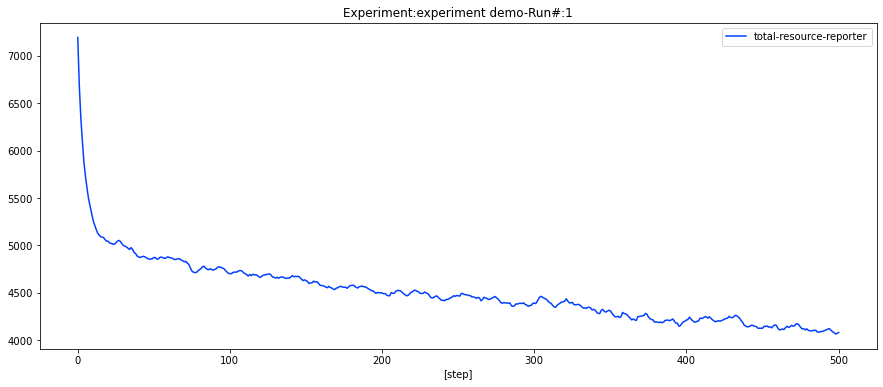

...Graph of total-patch-regrowth vs ticks


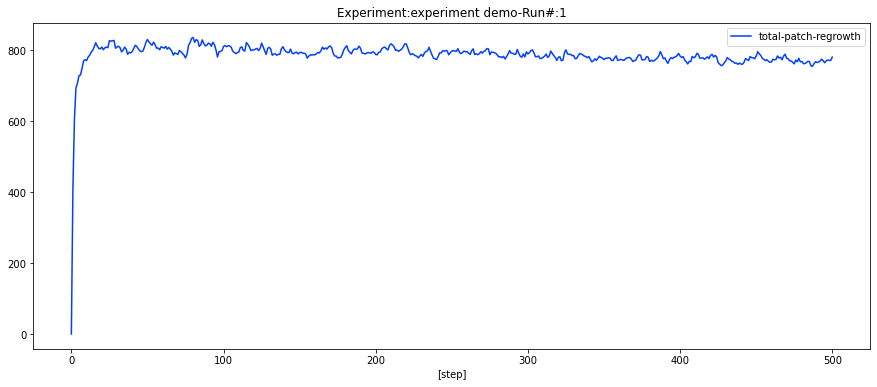

...Graph of total-turtle-resource-reporter vs ticks


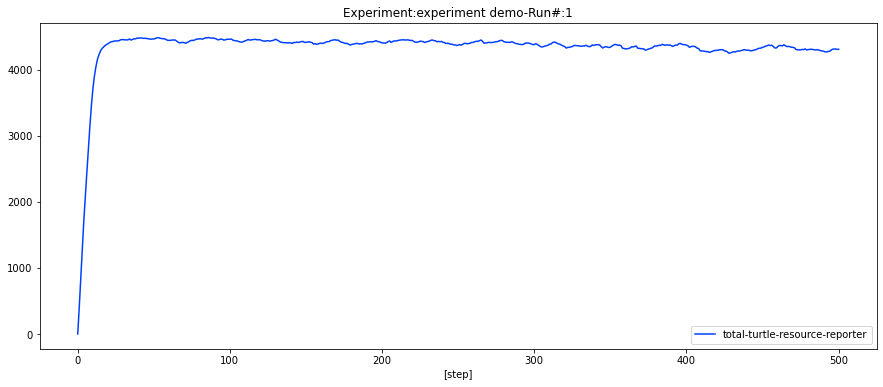

...Graph of total-quantity-harvested vs ticks


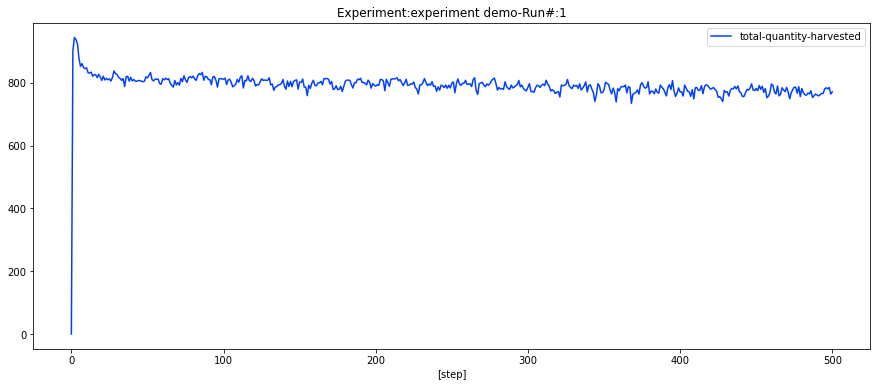

...Graph of number-of-hungry-turtles vs ticks


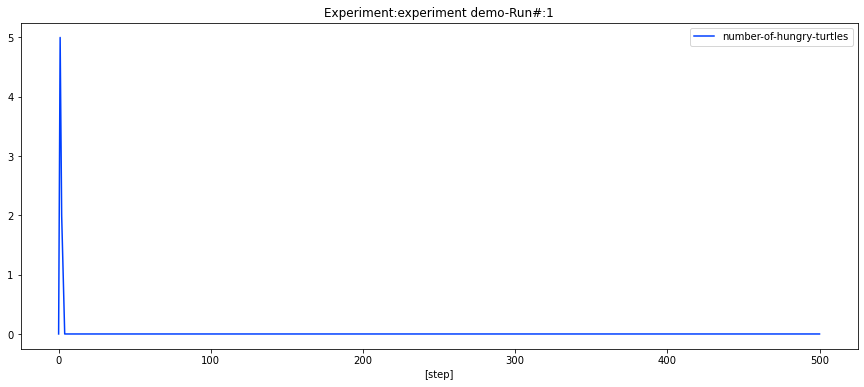

...Graph of total-wealth vs ticks


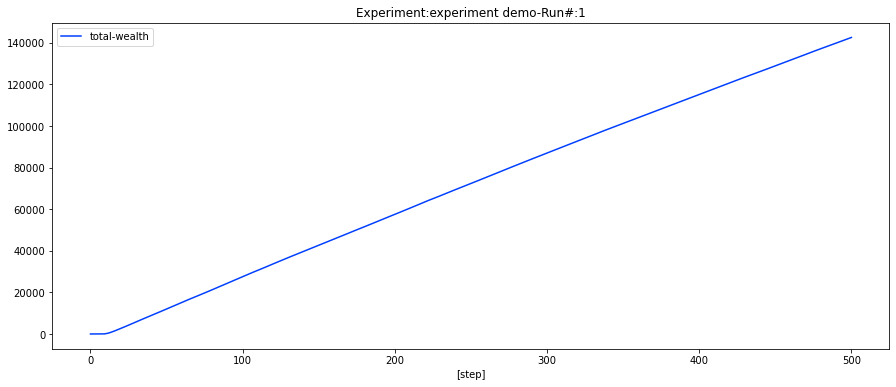

...Graph of total-food-exchanged vs ticks


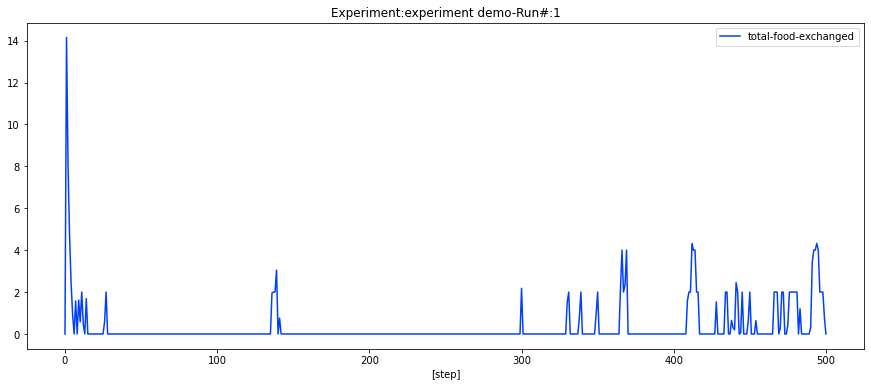

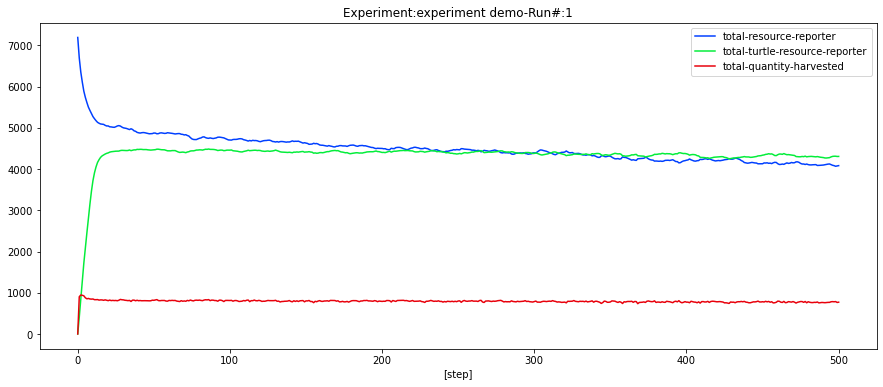

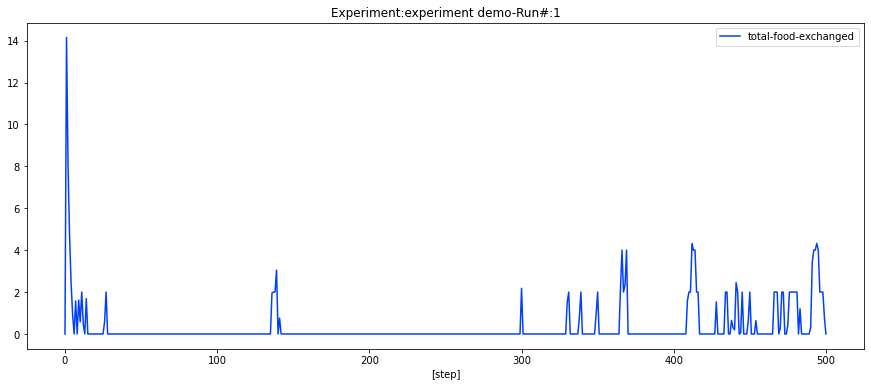

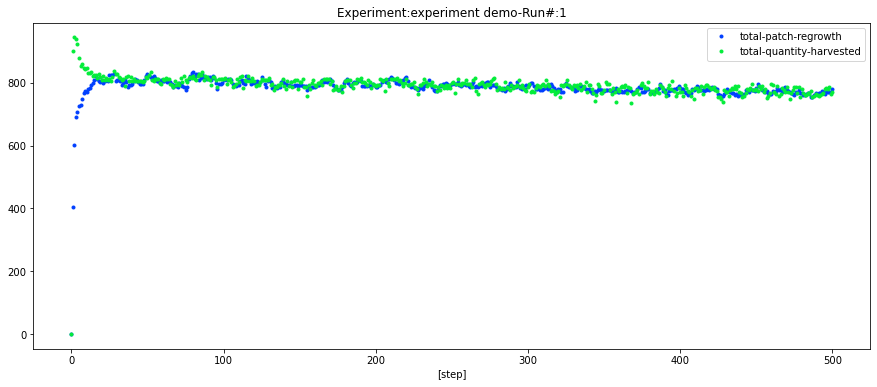

..processing run number  3
...Graph of total-resource-reporter vs ticks


/home/isischameleon/Dropbox/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


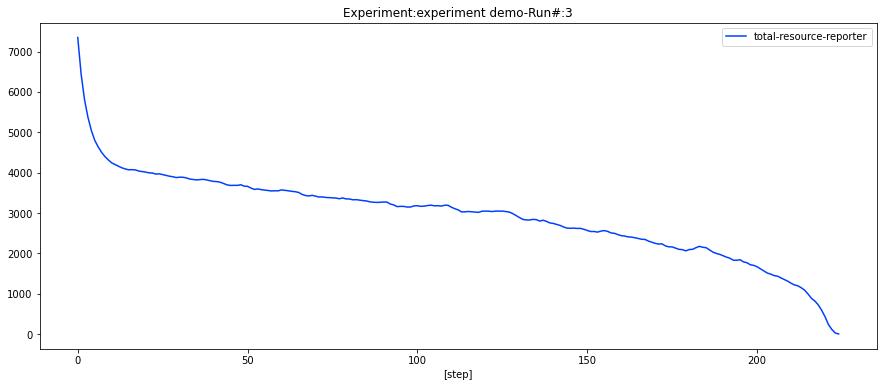

...Graph of total-patch-regrowth vs ticks


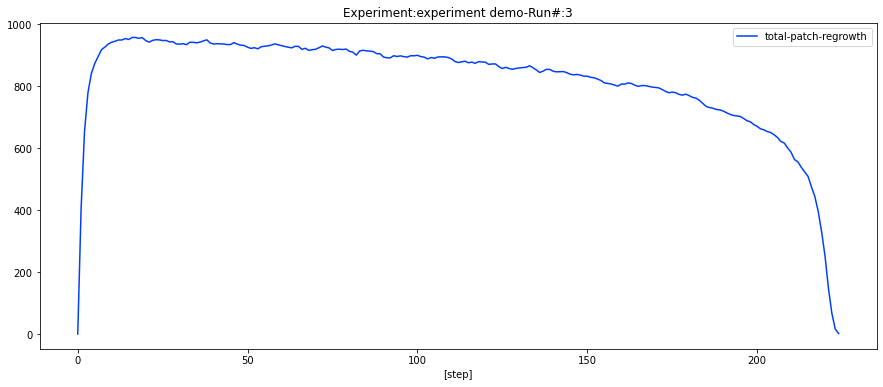

...Graph of total-turtle-resource-reporter vs ticks


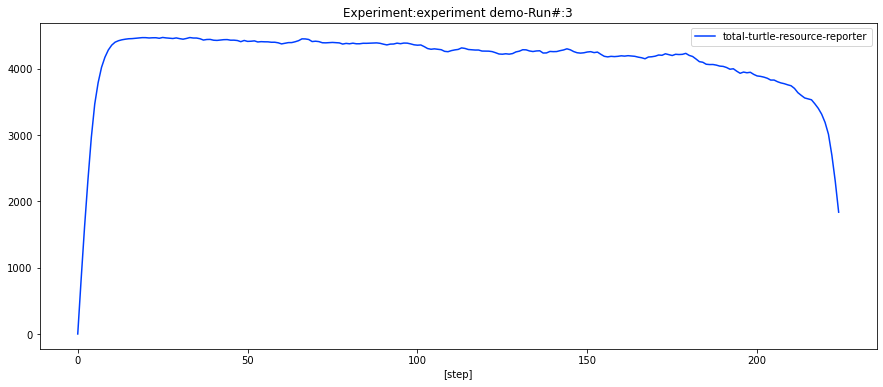

...Graph of total-quantity-harvested vs ticks


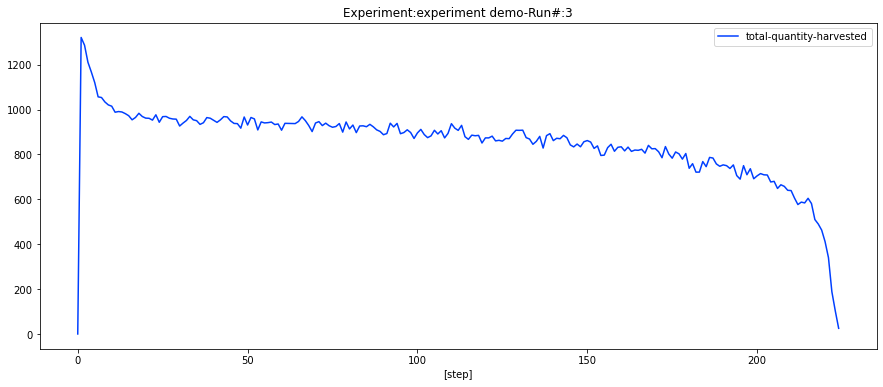

...Graph of number-of-hungry-turtles vs ticks


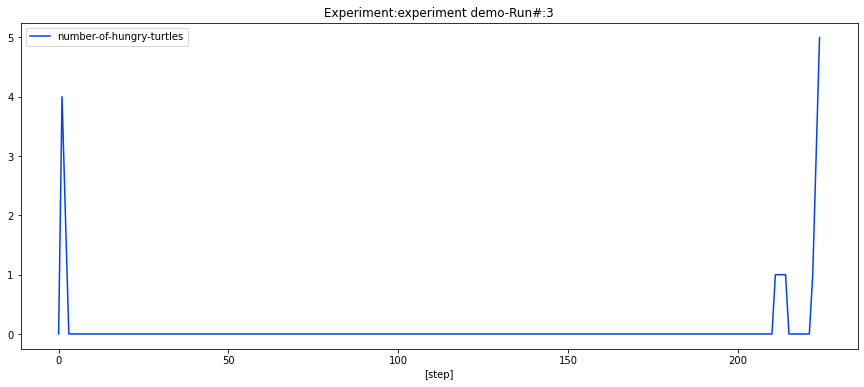

...Graph of total-wealth vs ticks


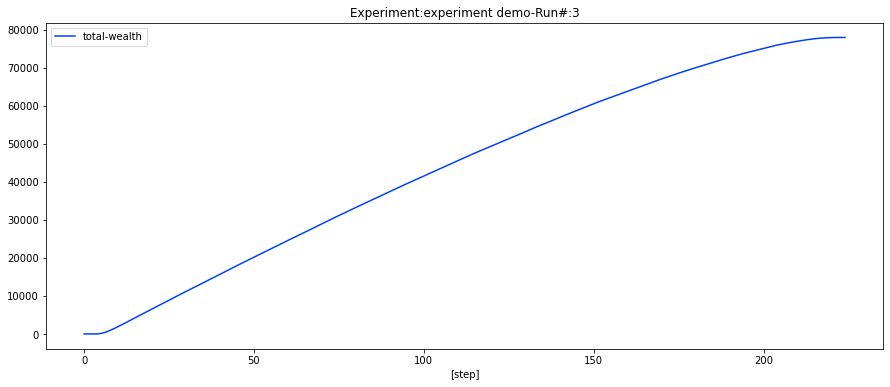

...Graph of total-food-exchanged vs ticks


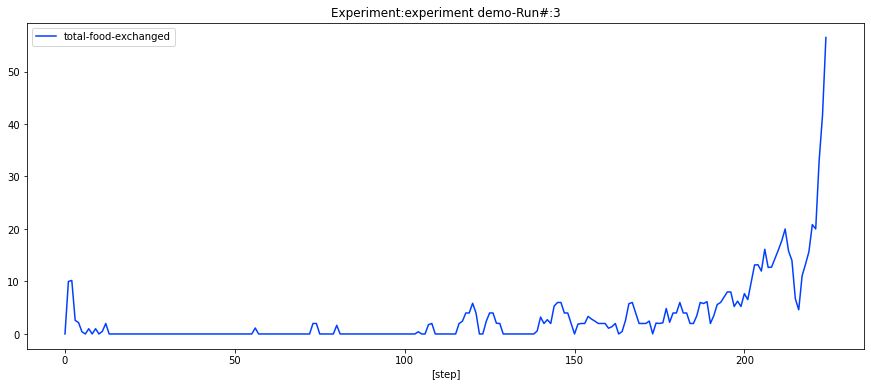

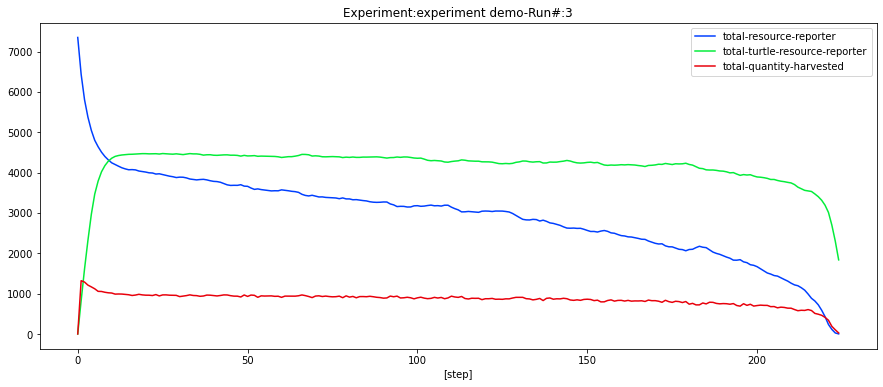

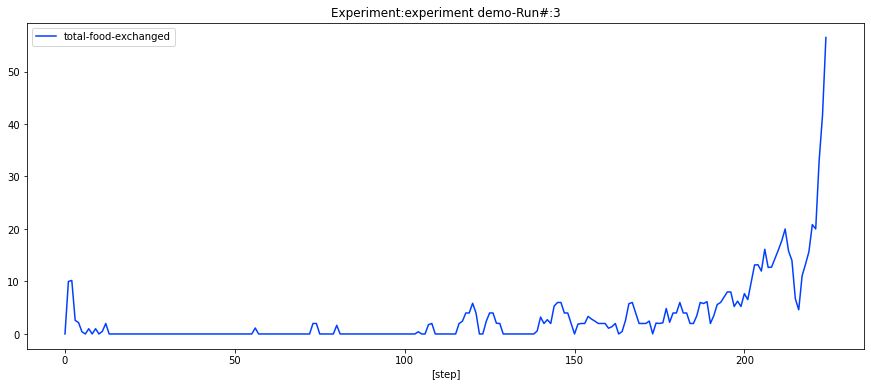

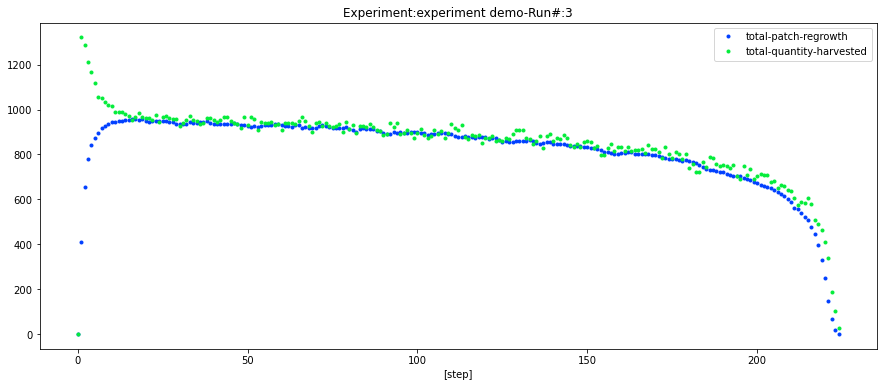

..processing run number  2
...Graph of total-resource-reporter vs ticks


/home/isischameleon/Dropbox/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


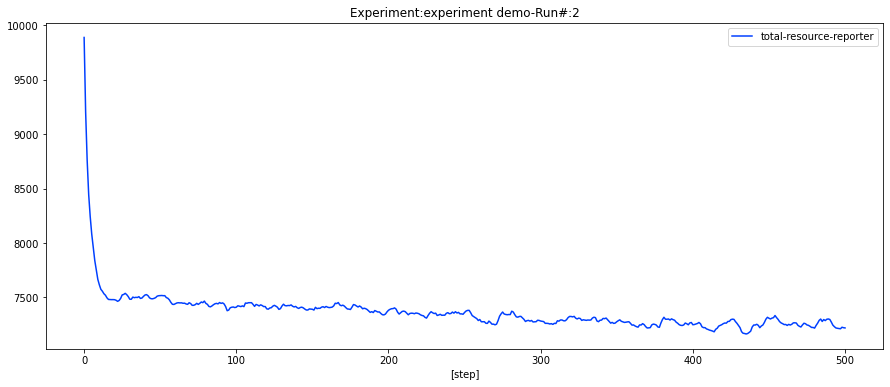

...Graph of total-patch-regrowth vs ticks


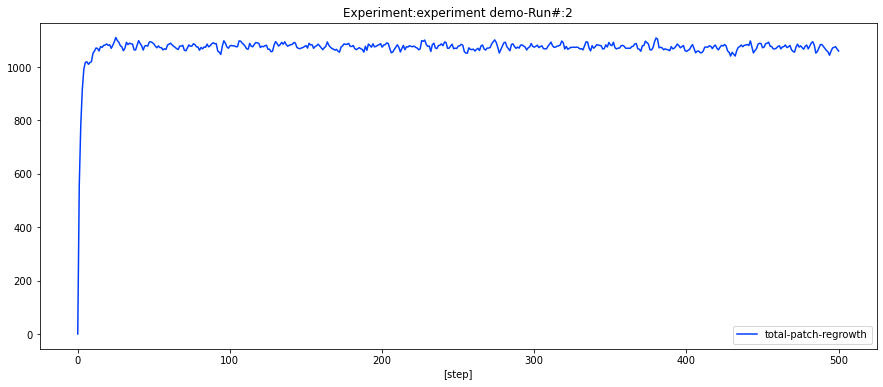

...Graph of total-turtle-resource-reporter vs ticks


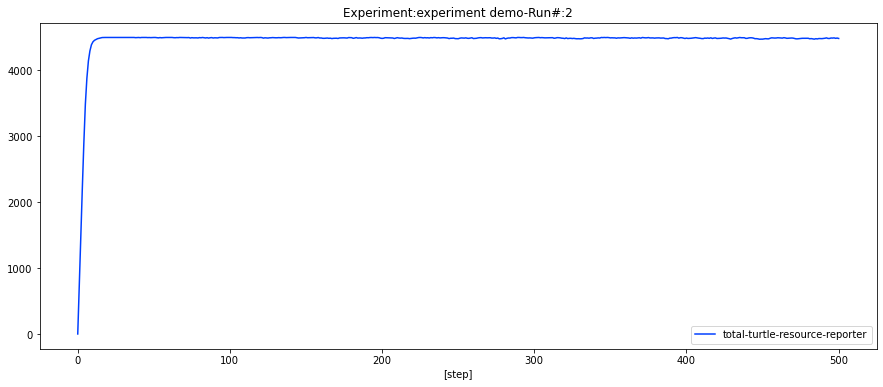

...Graph of total-quantity-harvested vs ticks


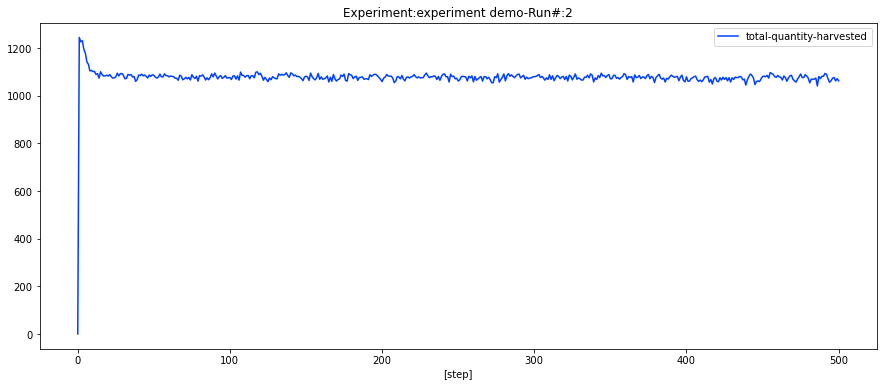

...Graph of number-of-hungry-turtles vs ticks


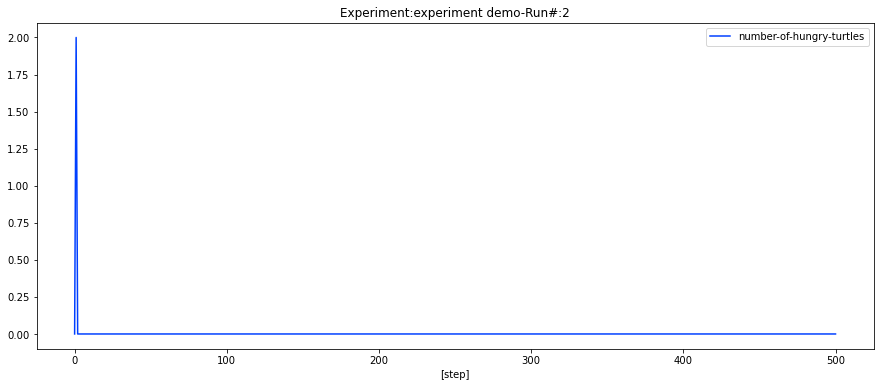

...Graph of total-wealth vs ticks


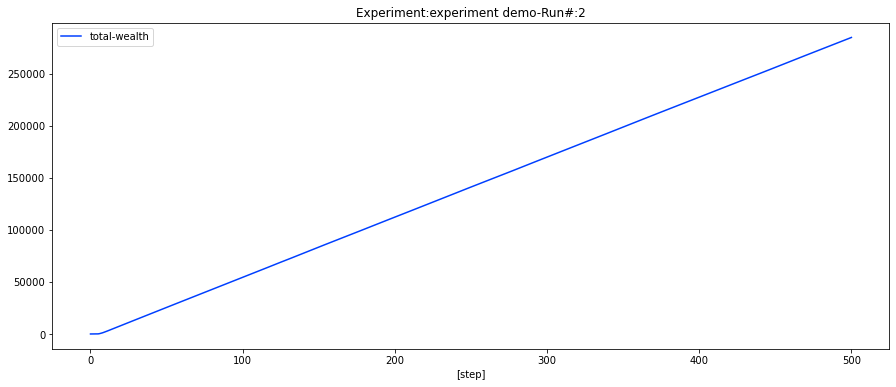

...Graph of total-food-exchanged vs ticks


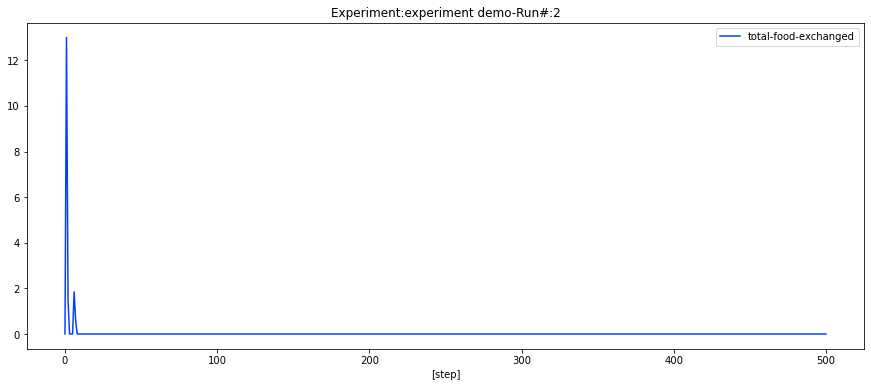

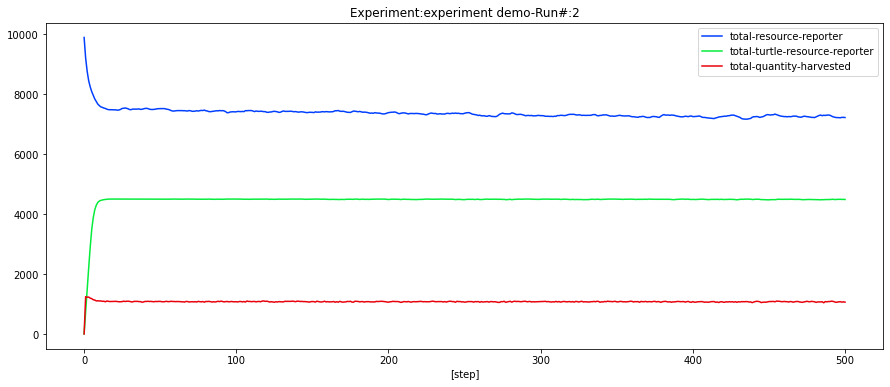

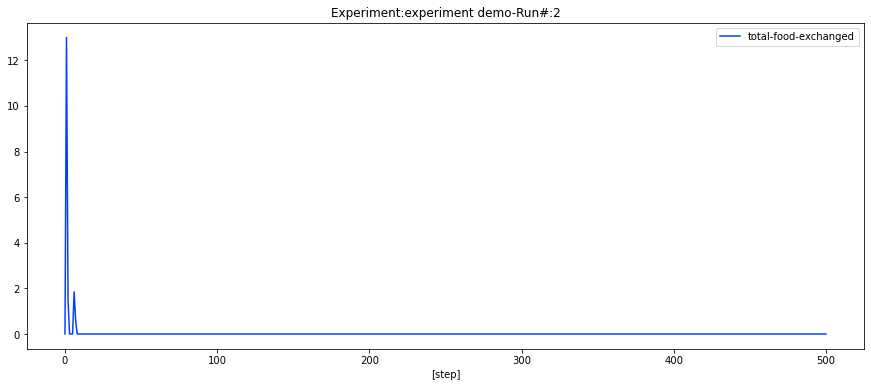

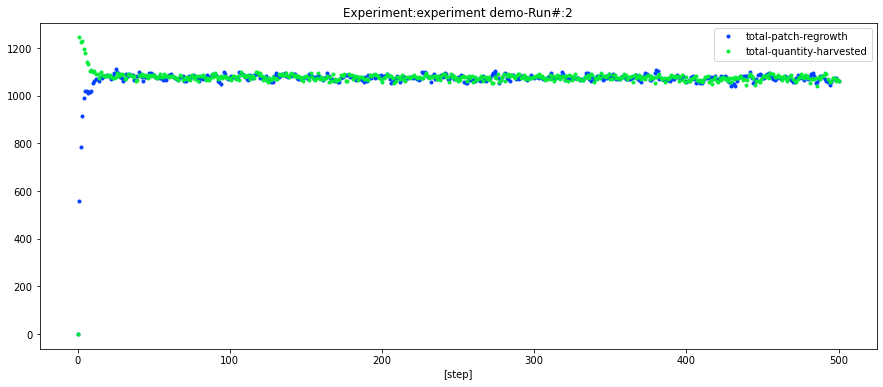

..processing run number  4
...Graph of total-resource-reporter vs ticks


/home/isischameleon/Dropbox/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


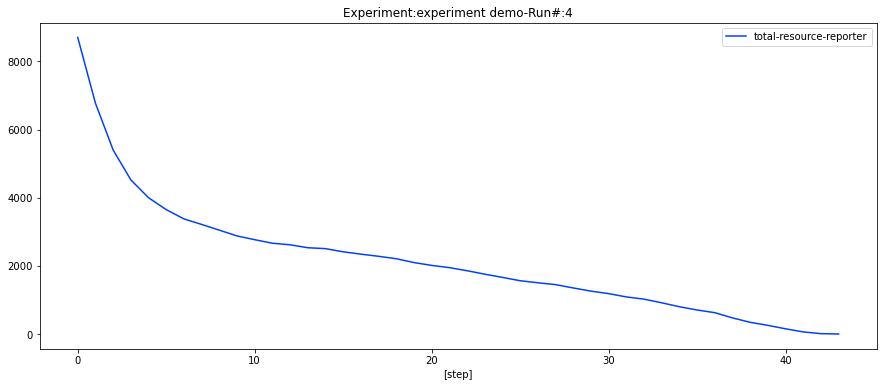

...Graph of total-patch-regrowth vs ticks


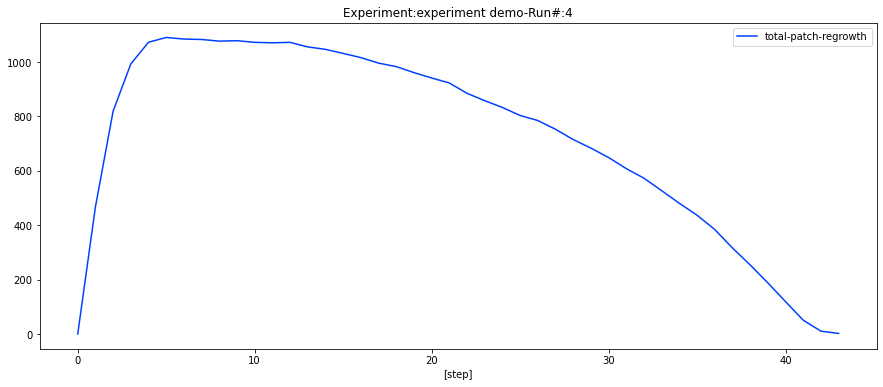

...Graph of total-turtle-resource-reporter vs ticks


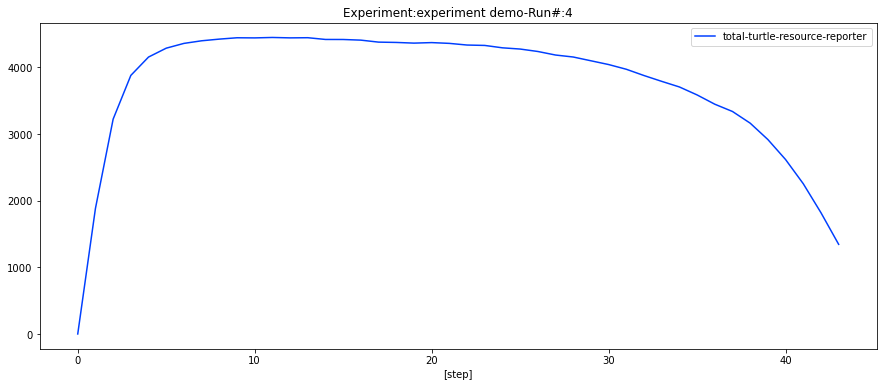

...Graph of total-quantity-harvested vs ticks


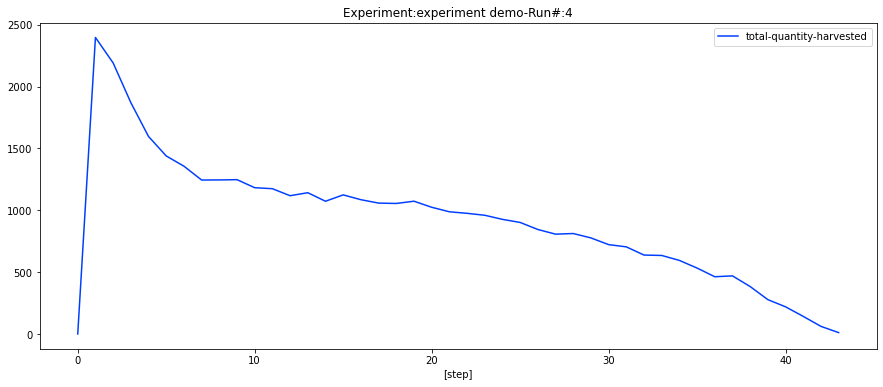

...Graph of number-of-hungry-turtles vs ticks


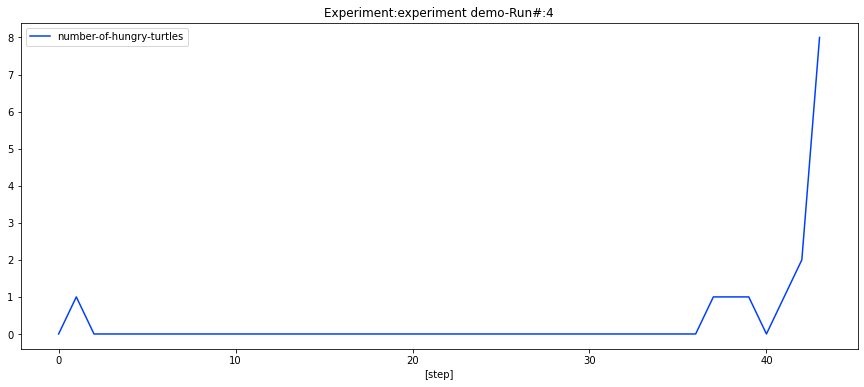

...Graph of total-wealth vs ticks


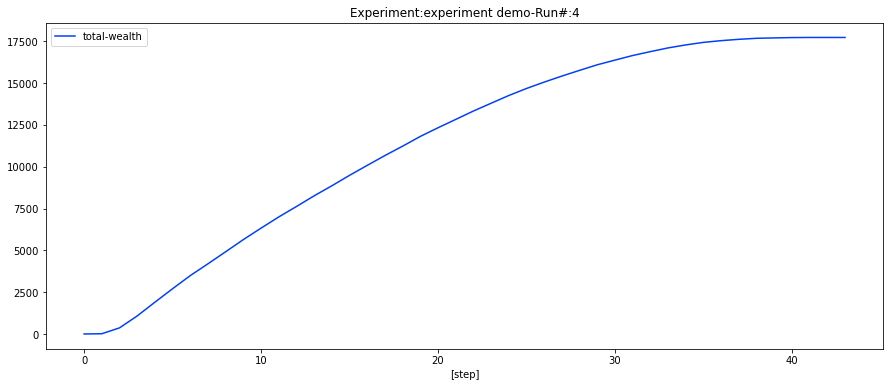

...Graph of total-food-exchanged vs ticks


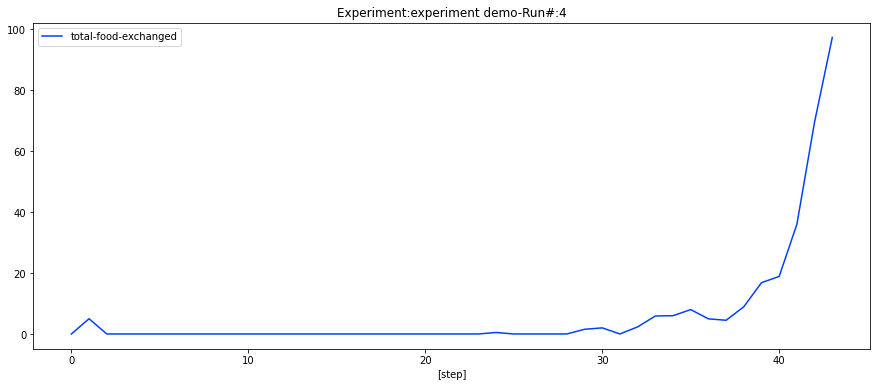

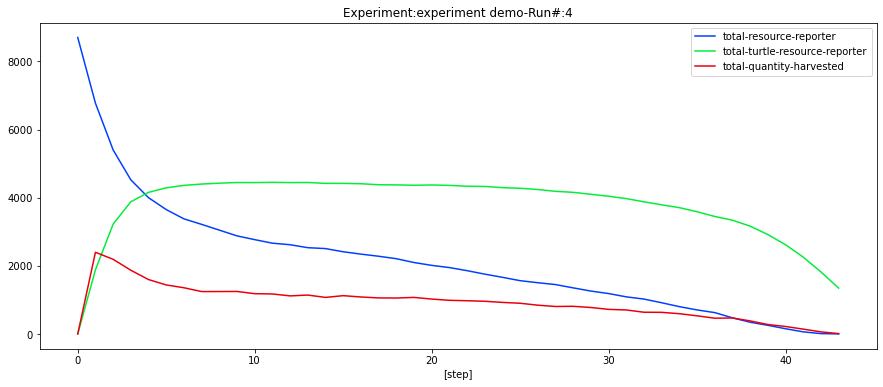

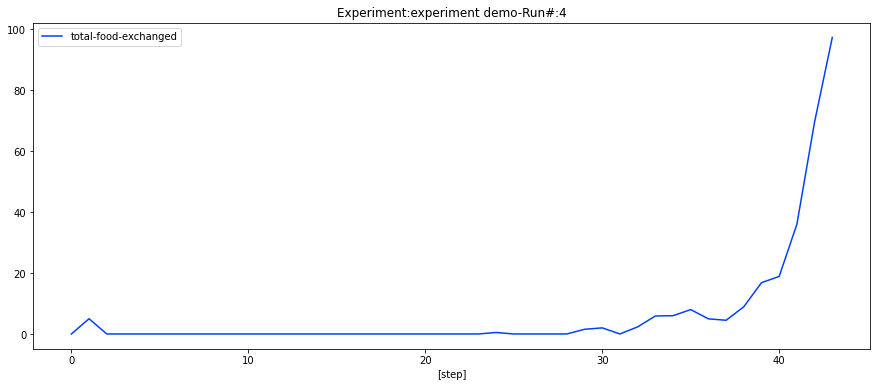

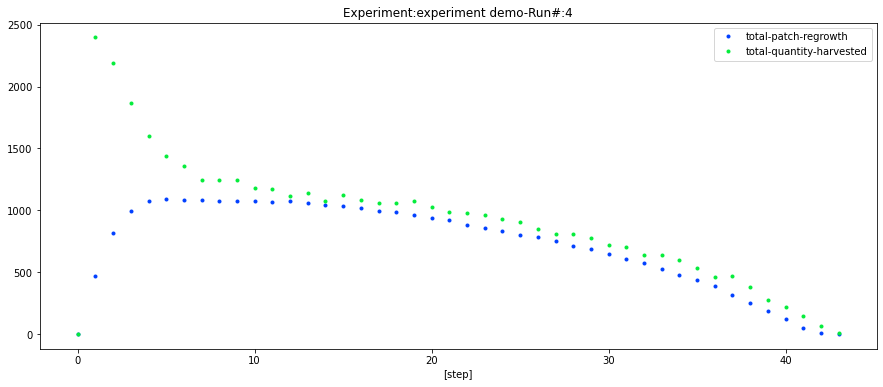

In [314]:
########### MAIN ###############################################
# Reading our first csv file 
# >>>>>>>>>>>>>>>>>  TO DO :  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# set csv_name with the name of your csv 
# >>>>>>>>>>>>>>>>>  TO DO :  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

#csv_name = 'network-commons experiment#1.3  500 turtles BACKPACK 3-table.csv'  
csv_name = 'network-commons experiment demo-table_decreasingfactordiv.csv'
df = read_netlogo_csv(csv_name)

# Calling the function to generate all sort of plots based on the csv file read

process_netlogo_experiments_dataframe(df)

In [315]:
# path = Path('/home/isischameleon/Dropbox/Coding/gitrepos/abm_commons_tragedy') 

def load_experiments_csv_files(csv_names: list = []):
    
    ''' Load multiple Netlogo experiments files into one dataframe df'''
    ''' e.g.csv_names = ['network-commons experiment #2.0 Network. min-degree 1-table.csv',
                         'network-commons experiment demo-table_decreasingfactordiv.csv']
    '''
    
    
    df_list = []
    
    if csv_names == []:
        os.chdir(path/'data')
        csv_names = glob.glob('*.{}'.format('csv'))
        os.chdir('..')
    
    print("Files about to be loaded into the dataframe : ", csv_names)
    
    for csv_name in csv_names:
        filename = path/'data'/csv_name
        df = read_netlogo_csv(csv_name)
        df_list.append(df)
        
    global_df = pd.concat(df_list, axis=0)
    
    return global_df
    
    


In [362]:
#for index in df.index:
#    print(index)

In [ ]:
# Functions to generate reports for multiple runs of the same experiment

def generate_resource_exchanged_plot_for_multiple_run(sdf, experiment):
    col_names = ['total-food-exchanged']
    title = "Experiment:{0} all runs".format(experiment))
    sdf[col_names].plot(figsize=(15, 6), title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_QtyExchangedBetweenTurtles_Each_Tick.png"
                 .format(experiment, run_number, col_names));

def generate_qty_harvested_vs_regrown_plot_for_multiple_run(sdf, experiment):
    #'total-patch-regrowth','total-quantity-harvested' vs time
    col_names=['total-patch-regrowth','total-quantity-harvested']
    title = "Experiment:{0} all runs".format(experiment)
    sdf[col_names].plot(figsize=(15, 6), style='.', title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_QtyHarvested_vs_QtyRegrown.png"
                 .format(experiment, run_number, col_names));
    
def generate_final_turtle_group_plots_for_multiple_run(sdf, experiment):
    pass

def generate_total_resource_plot_for_multiple_run(sdf, experiment):
    # total resources is a plot vs time of the following reporters 
    #'total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested'
    col_names=['total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested']
    title = "Experiment:{0} all runs".format(experiment)
    #print(sdf.index.name)
    #print(sdf.head())
    
    #df.reset_index(drop=False, inplace=True)
    #df.set_index(['[step]','[run number]', append=False, inplace=True)
    #ax = df1.plot()
    #df2.plot(ax=ax)
    
    fig, ax = plt.subplots()
    #ax.set_xlabel("ticks")
    ax.set_ylabel("quantity fo resource")
    
    run_number=""
    for index in sdf.index:
        if run_number != index[0]:
            # change of run in the same experiment
            run_number = index[0]
            ssdf=sdf.xs( (run_number) )
            #print(ssdf.head())
            print("Generating graph for run number : ", run_number)
            ssdf[col_names].plot( figsize=(15, 6), 
                      title=title, ax=ax, label="Run{0}".format(run_number))
            
            
            
            
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_Total_Resources_{2}_vs_ticks.png"
                     .format(experiment, run_number, col_names));

In [360]:
def process_netlogo_experiments_global(df):
    
    df.sort_index(inplace=True)
    experiment=""
    run_number=""
    #for index, row in df.iterrows():
    for index in df.index:
        if experiment != index[0]:
            # reading a new changing experiment
            experiment = index[0]
            print("Processing experiment :", experiment)
            run_number = index[1]
            print("..Processing run number :", run_number)
            generate_all_reports_per_run(df, experiment, run_number)
            
        elif run_number != index[1]:
            # change of run in the same experiment
            run_number = index[1]
            sliced_df = sliced_df=df.xs( (experiment,run_number) )
            generate_all_reports_per_run(df, experiment, run_number)
            
    

def generate_all_reports_per_run(df, experiment, run_number):
    sliced_df=df.xs( (experiment,run_number) )
    generate_reporters_vs_time(sliced_df, experiment, run_number)
    generate_total_resource_plot(sliced_df, experiment, run_number)
    generate_resource_exchanged_plot(sliced_df, experiment, run_number)
    generate_qty_harvested_vs_regrown_plot(sliced_df, experiment, run_number)
    generate_final_turtle_group_plots(sliced_df, experiment, run_number) 
    
def generate_all_reports_per_experiment(df, experiment):
    sliced_df=df.xs( (experiment) )
    #1 - generate the total resource plot for multiple runs and the same experiment
    generate_total_resource_plot_for_multiple_run(sliced_df, experiment)
    

         

Files about to be loaded into the dataframe :  ['network-commons experiment demo-table_decreasingfactordiv.csv', 'network-commons experiment #2.0 Network. min-degree 1-table.csv', 'network-commons experiment #2.1 Network. min-degree 1 5 runs-table.csv']
Processing experiment : experiment #2.0 Network. min-degree 1
..Processing run number : 1
...Graph of total-resource-reporter vs ticks


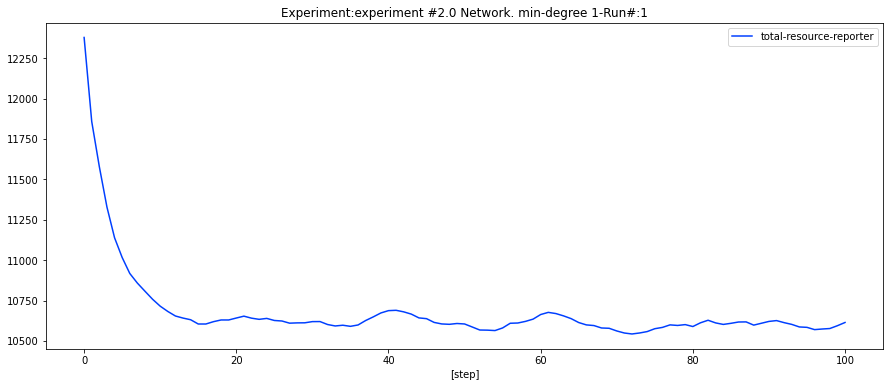

...Graph of total-patch-regrowth vs ticks


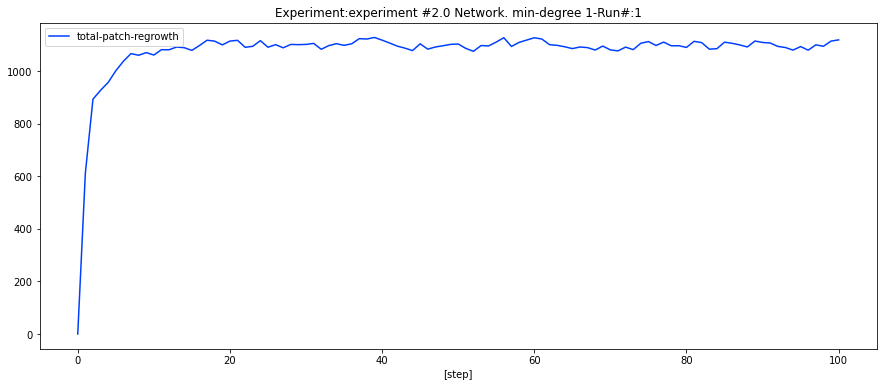

...Graph of total-turtle-resource-reporter vs ticks


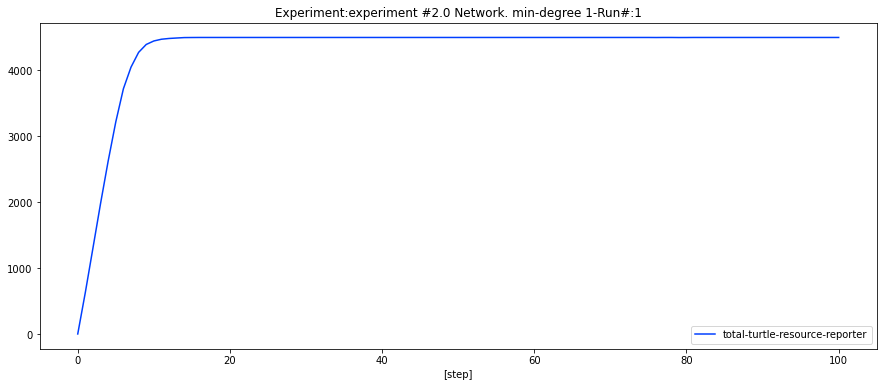

...Graph of total-quantity-harvested vs ticks


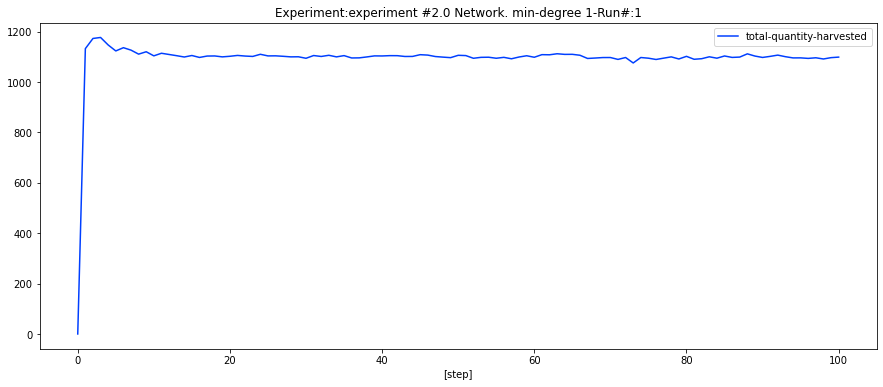

...Graph of number-of-hungry-turtles vs ticks


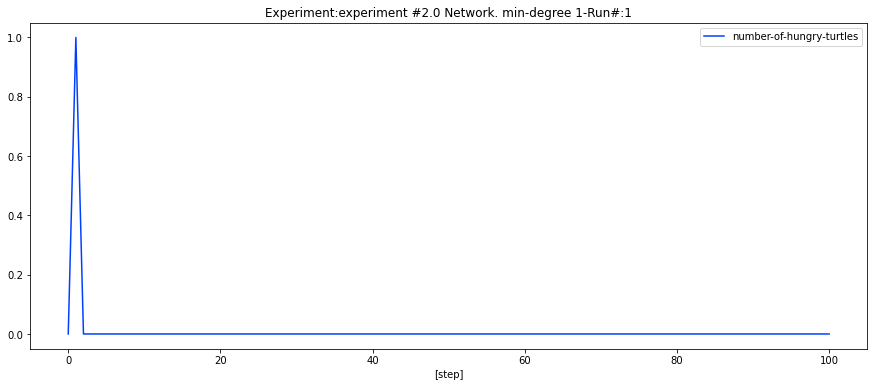

...Graph of total-wealth vs ticks


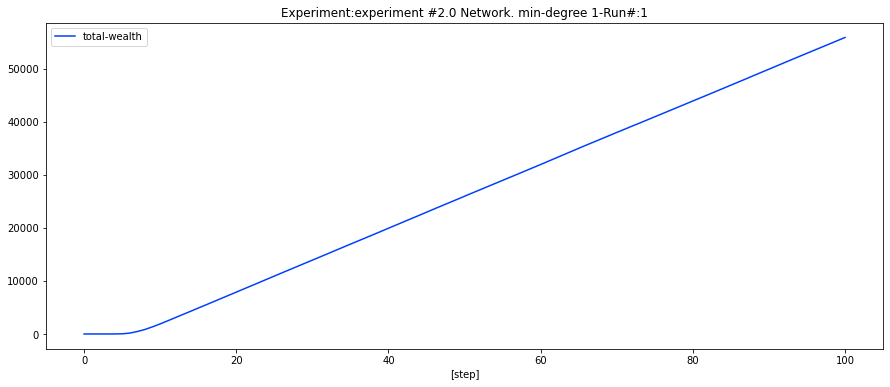

...Graph of total-food-exchanged vs ticks


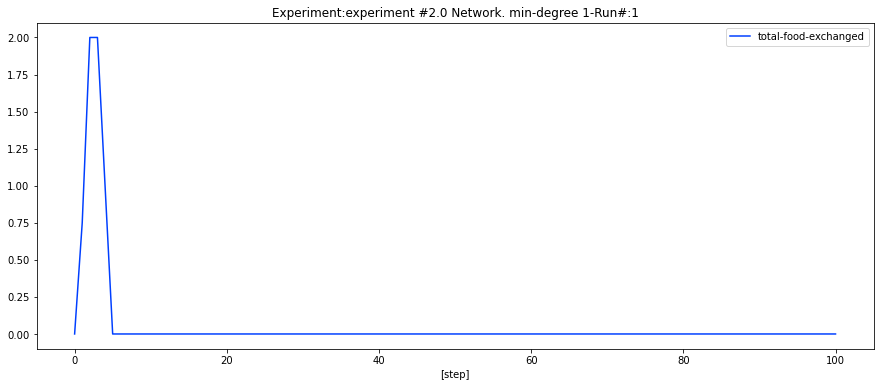

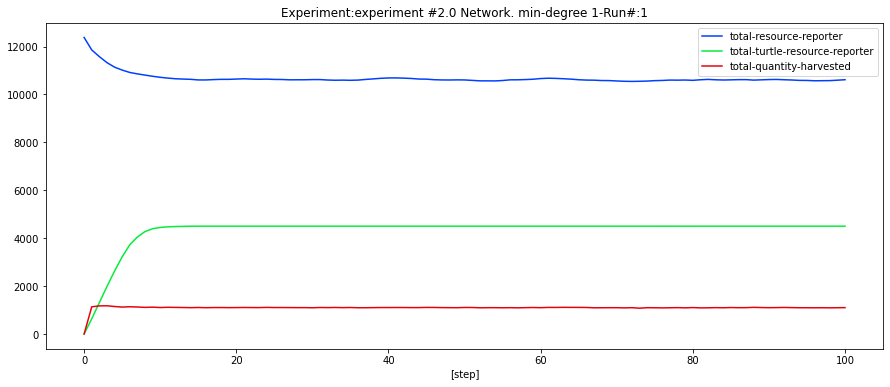

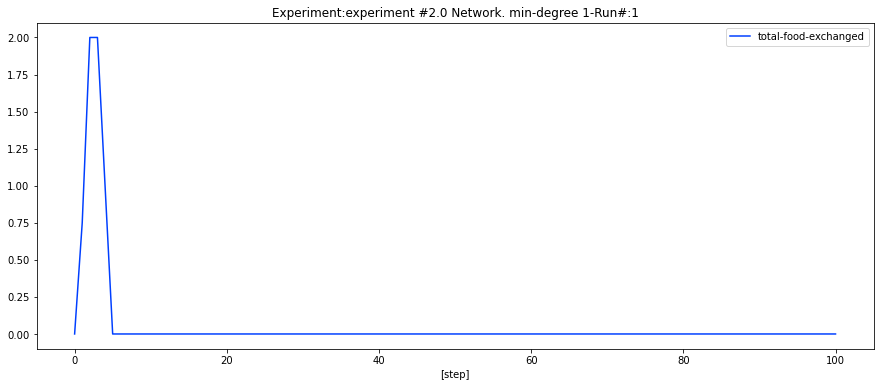

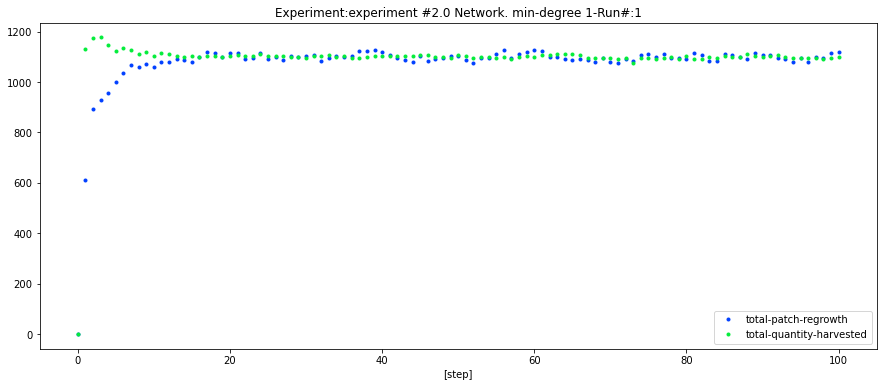

Processing experiment : experiment #2.1 Network. min-degree 1 5 runs
..Processing run number : 1
...Graph of total-resource-reporter vs ticks


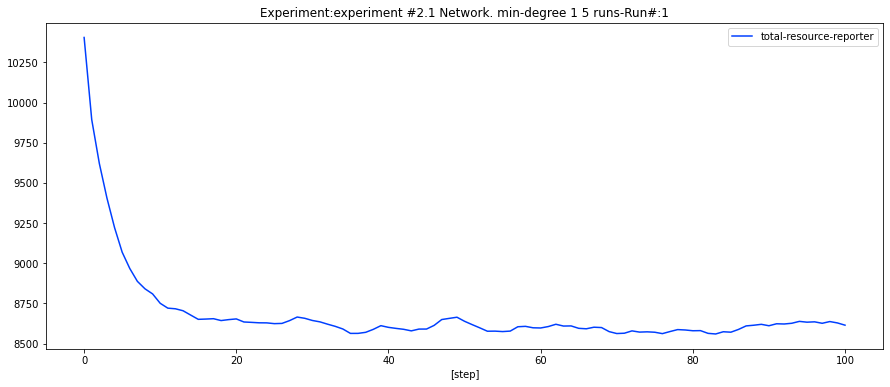

...Graph of total-patch-regrowth vs ticks


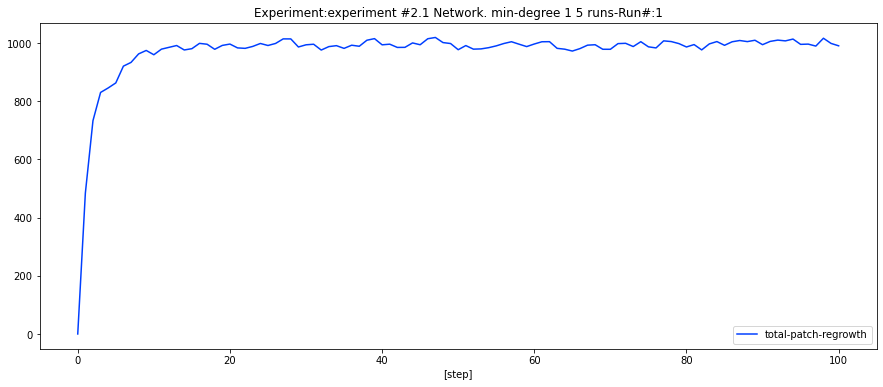

...Graph of total-turtle-resource-reporter vs ticks


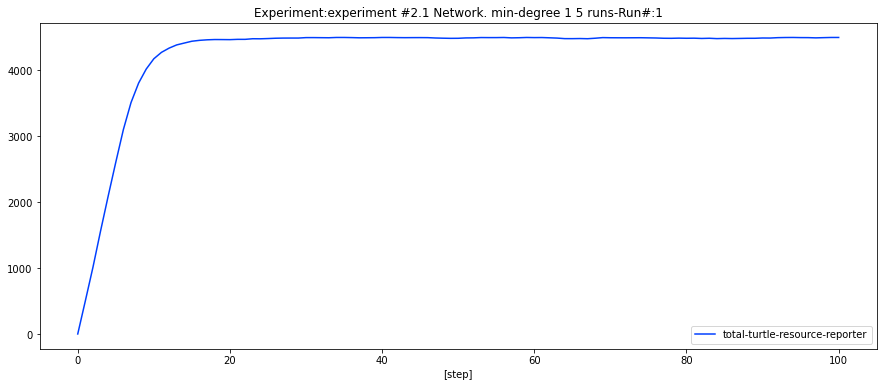

...Graph of total-quantity-harvested vs ticks


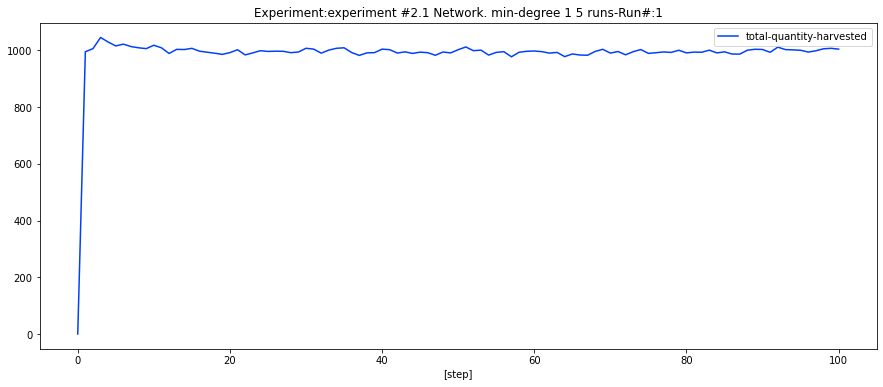

...Graph of number-of-hungry-turtles vs ticks


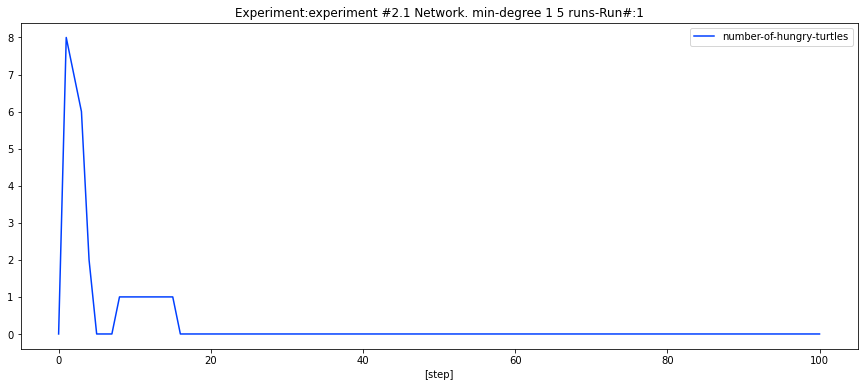

...Graph of total-wealth vs ticks


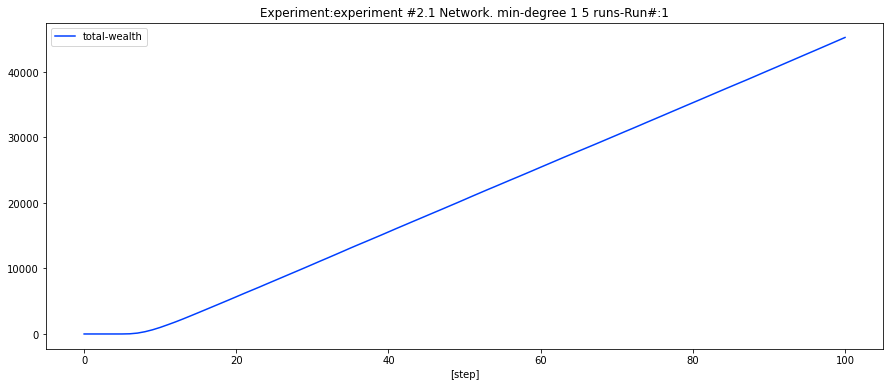

...Graph of total-food-exchanged vs ticks


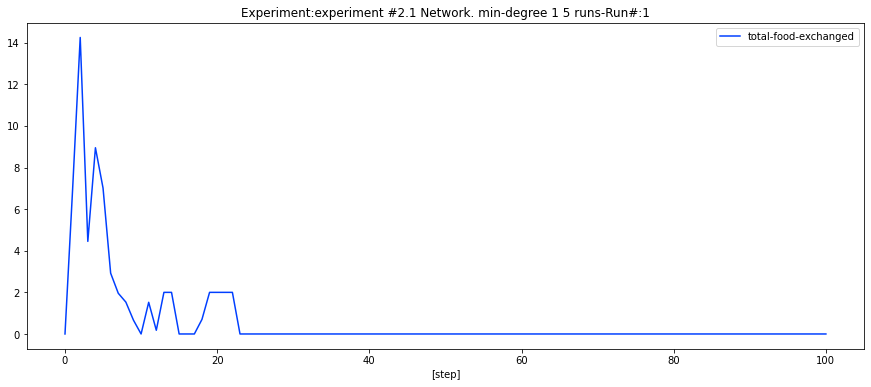

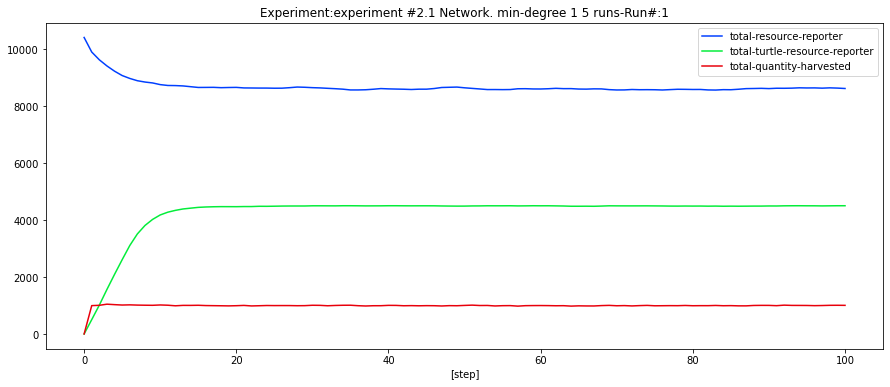

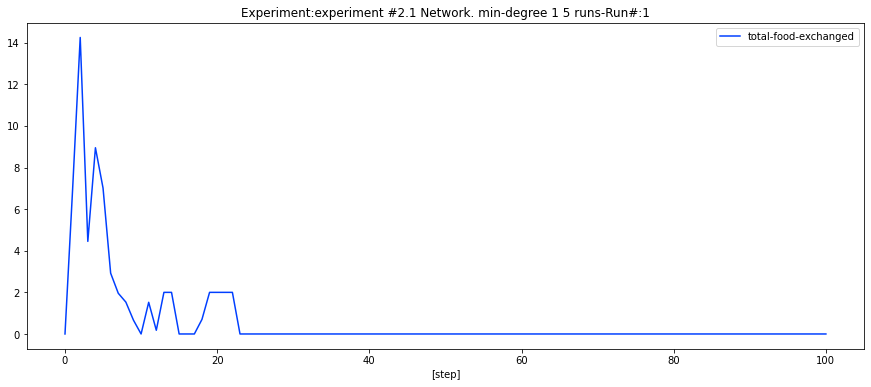

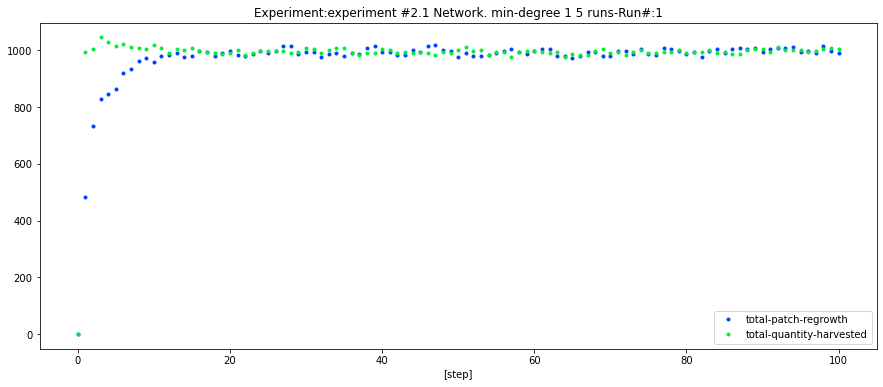

...Graph of total-resource-reporter vs ticks


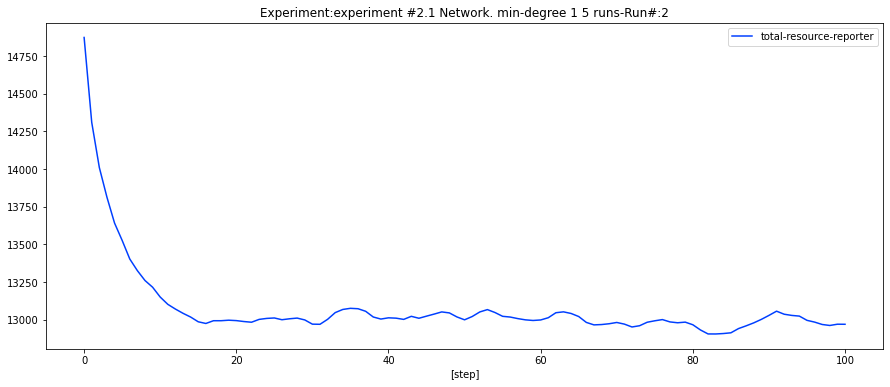

...Graph of total-patch-regrowth vs ticks


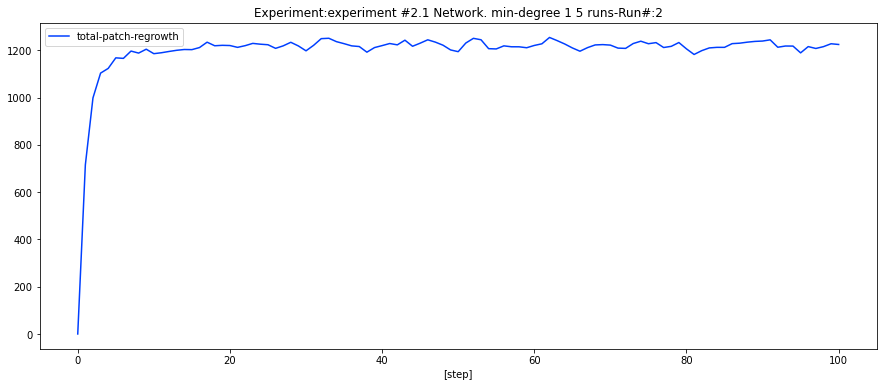

...Graph of total-turtle-resource-reporter vs ticks


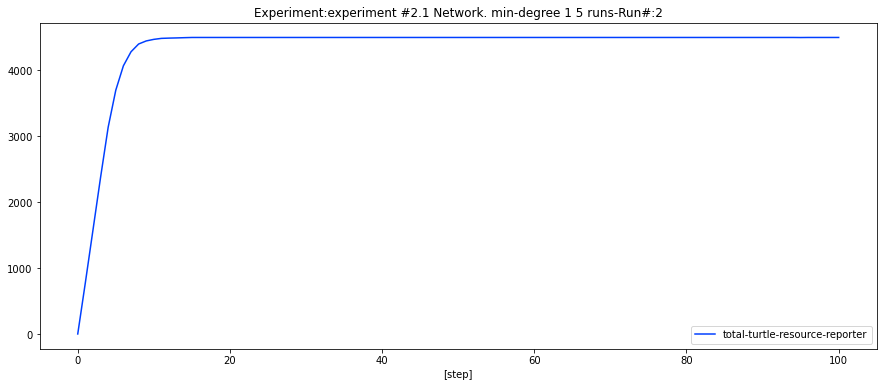

...Graph of total-quantity-harvested vs ticks


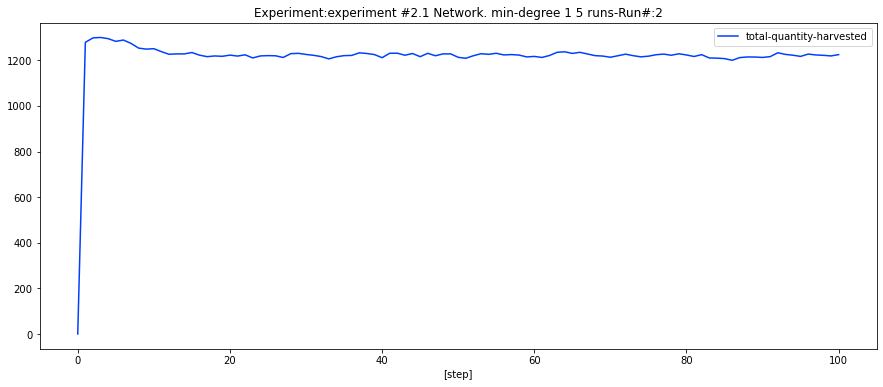

...Graph of number-of-hungry-turtles vs ticks


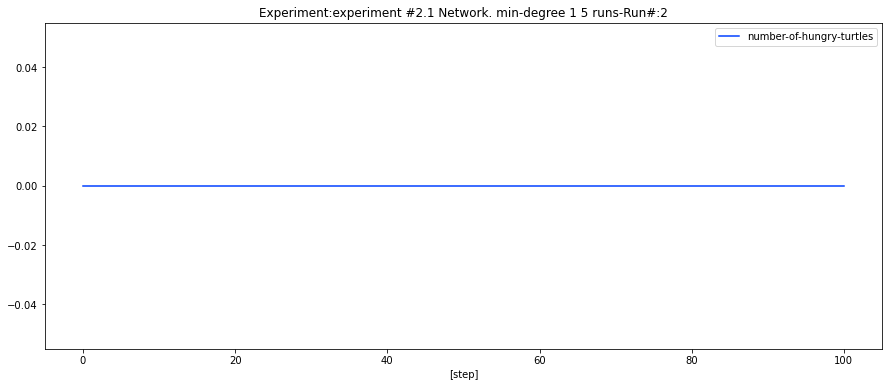

...Graph of total-wealth vs ticks


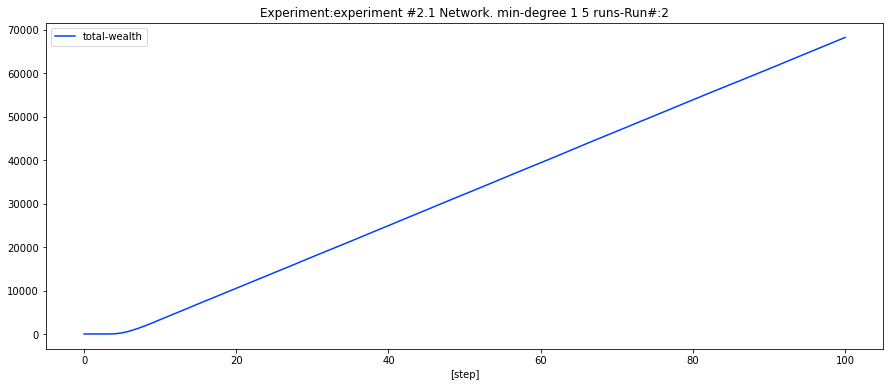

...Graph of total-food-exchanged vs ticks


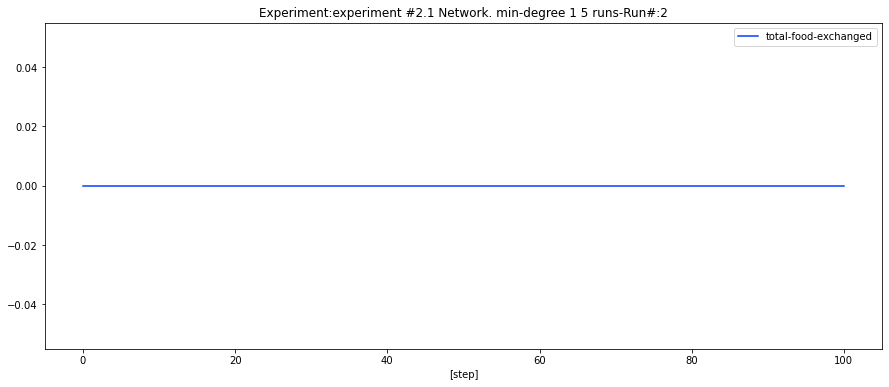

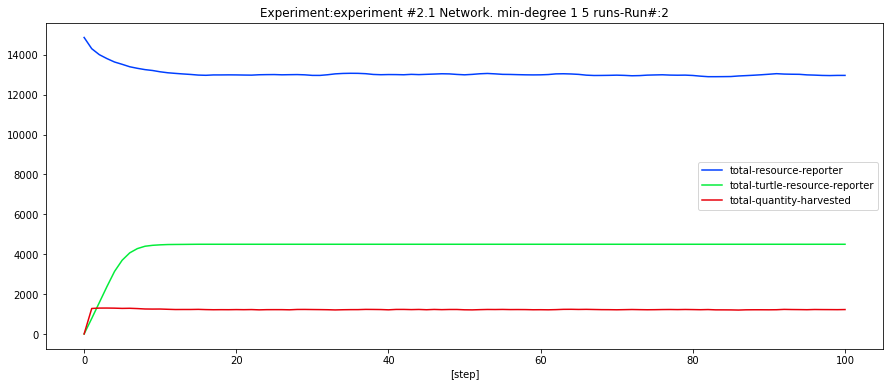

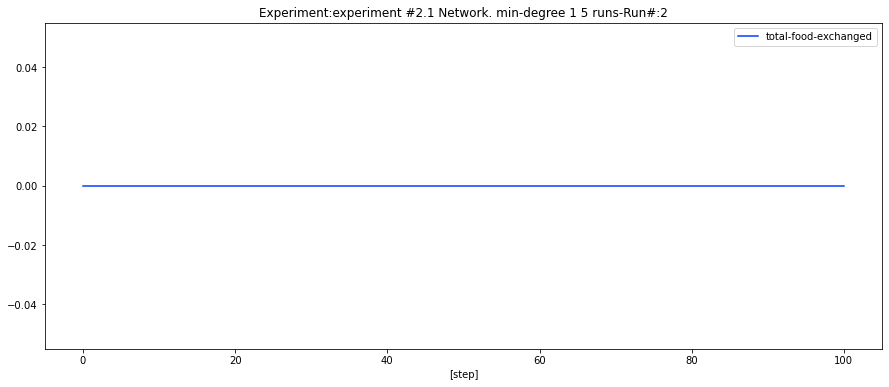

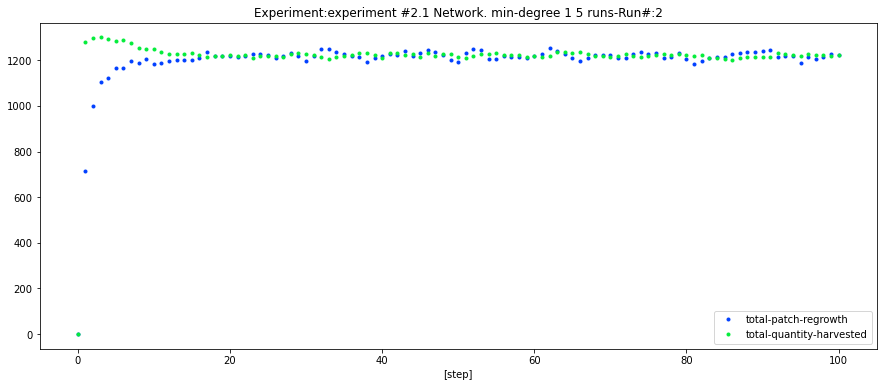

...Graph of total-resource-reporter vs ticks


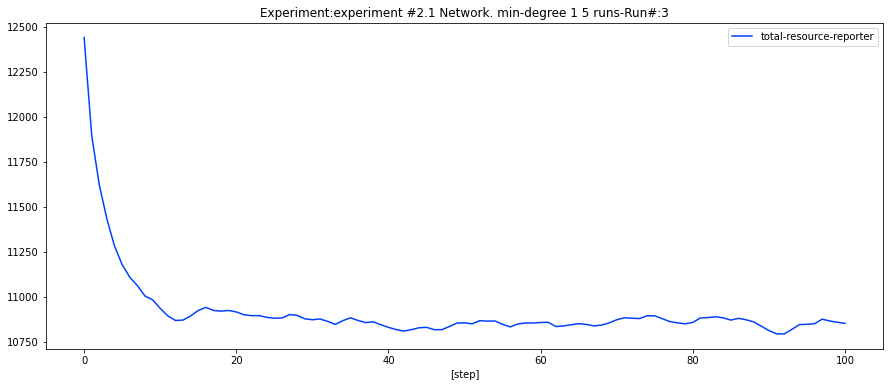

...Graph of total-patch-regrowth vs ticks


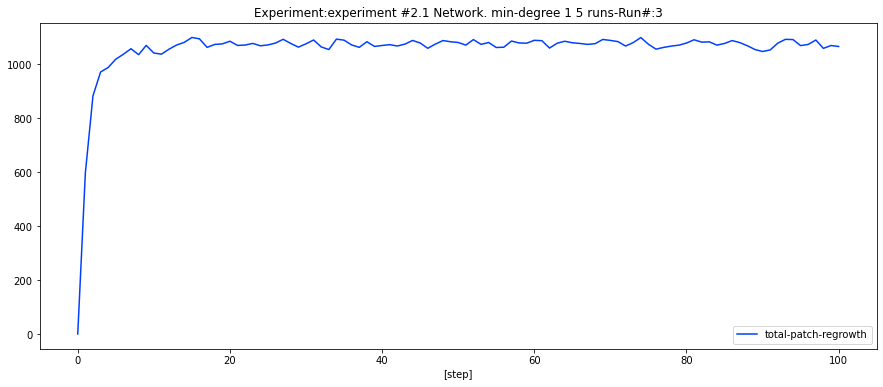

...Graph of total-turtle-resource-reporter vs ticks


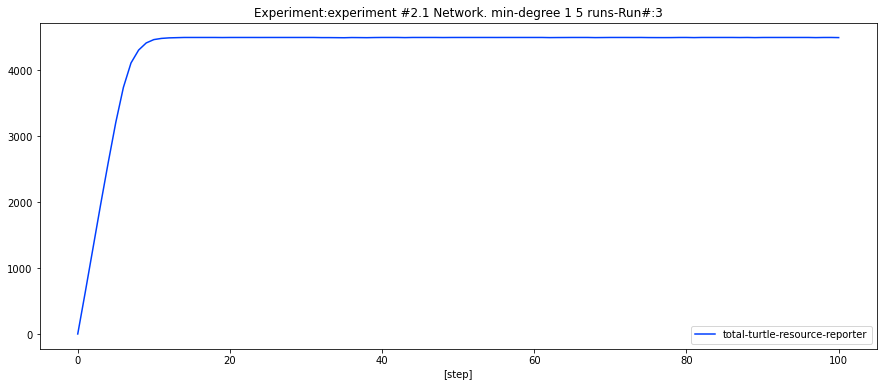

...Graph of total-quantity-harvested vs ticks


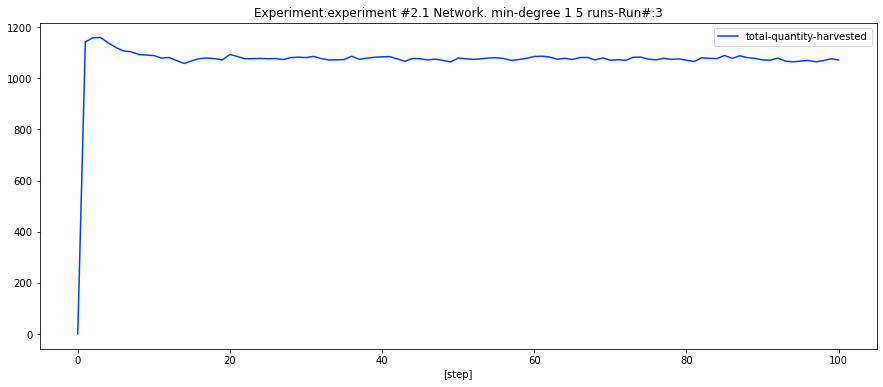

...Graph of number-of-hungry-turtles vs ticks


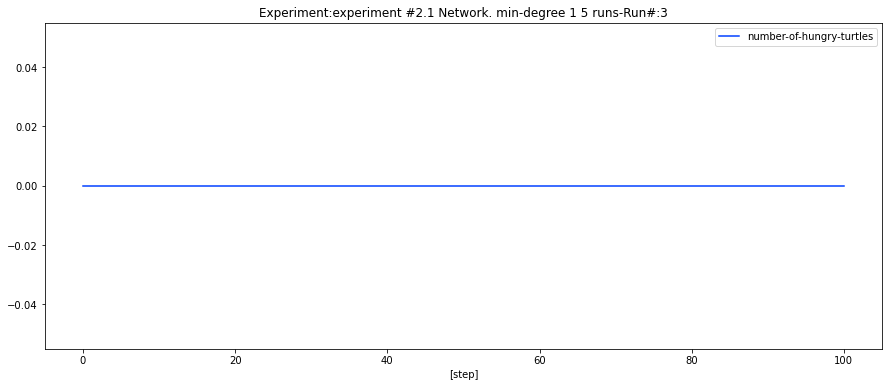

...Graph of total-wealth vs ticks


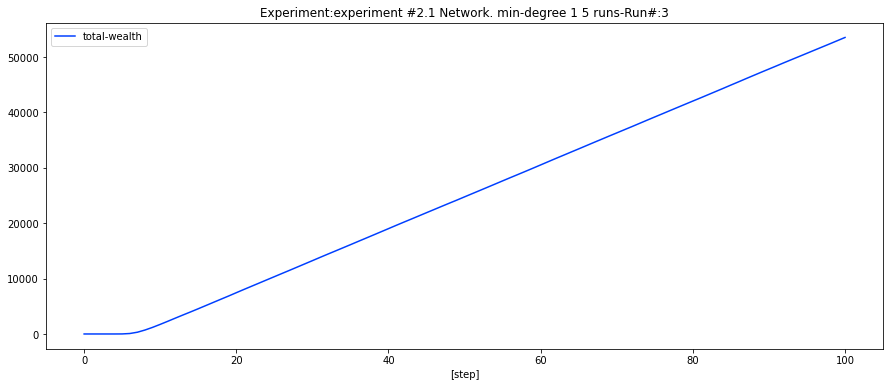

...Graph of total-food-exchanged vs ticks


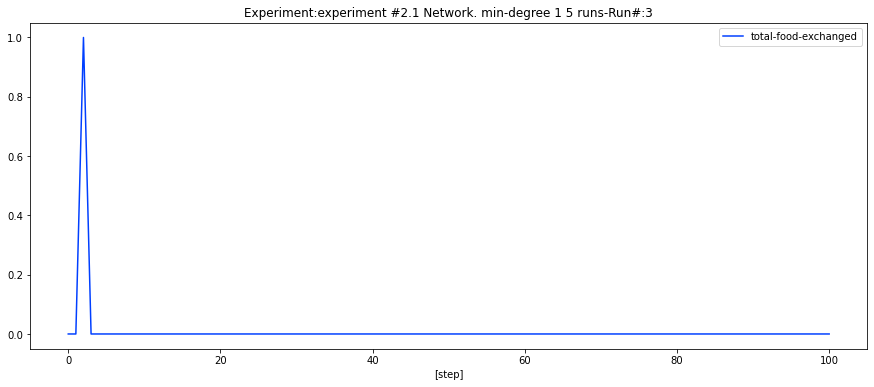

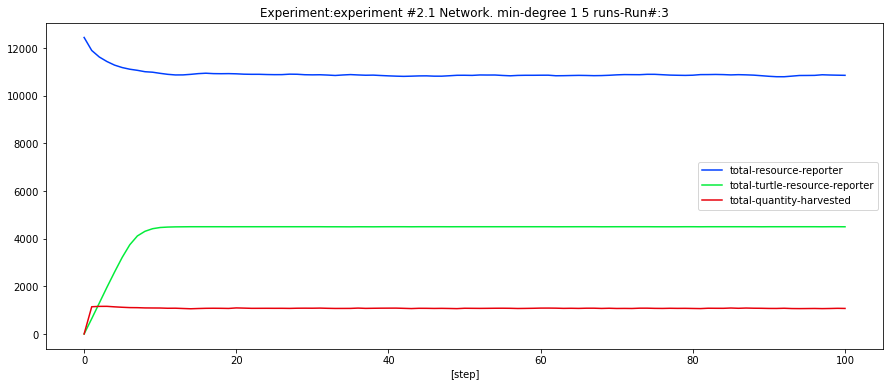

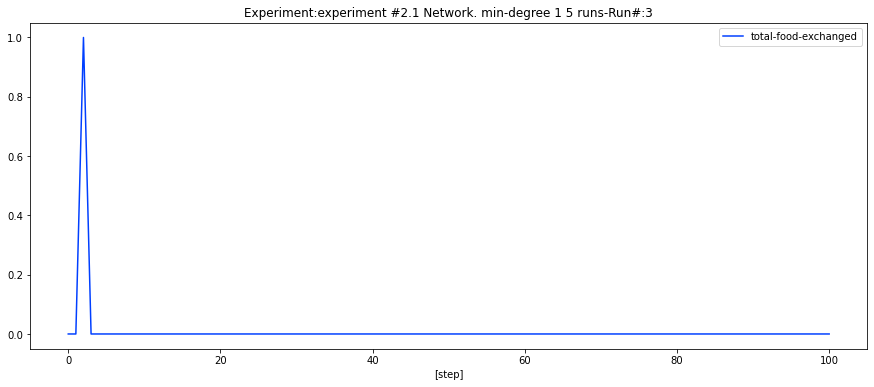

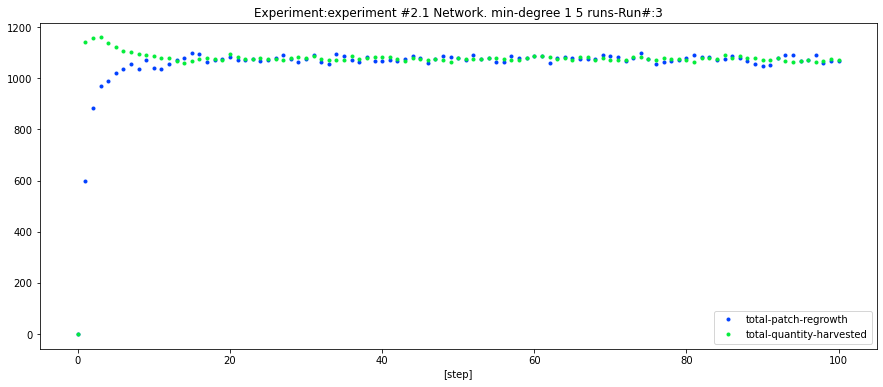

...Graph of total-resource-reporter vs ticks


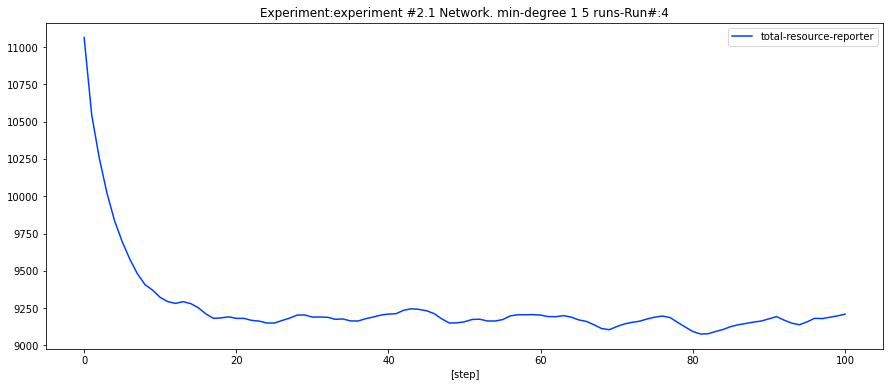

...Graph of total-patch-regrowth vs ticks


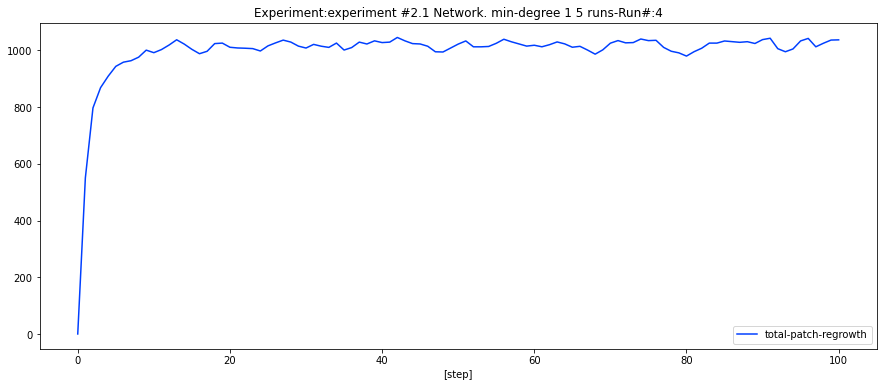

...Graph of total-turtle-resource-reporter vs ticks


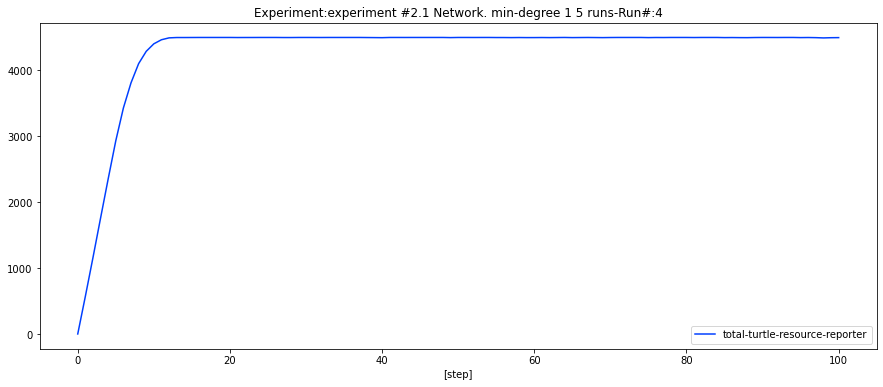

...Graph of total-quantity-harvested vs ticks


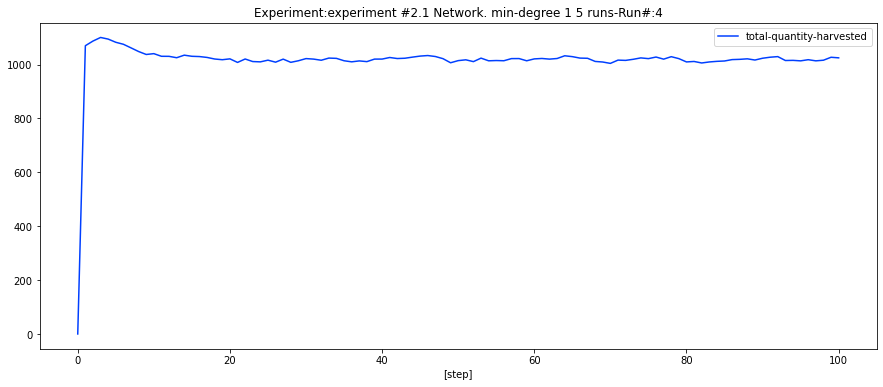

...Graph of number-of-hungry-turtles vs ticks


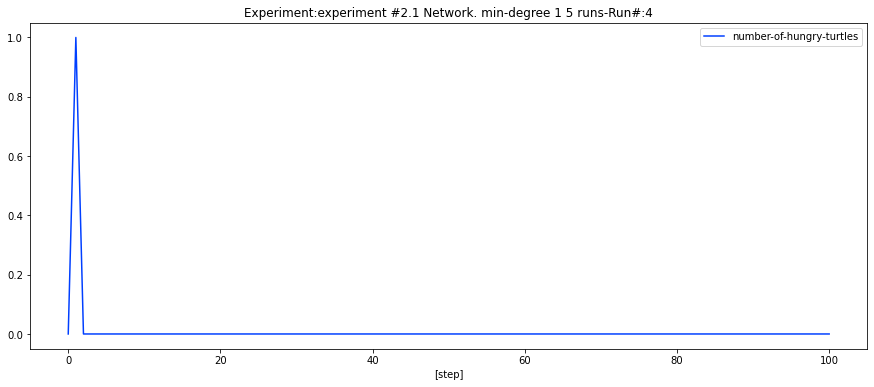

...Graph of total-wealth vs ticks


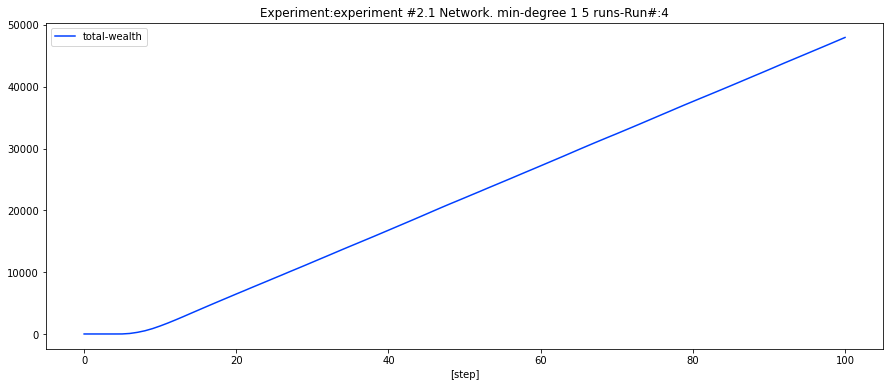

...Graph of total-food-exchanged vs ticks


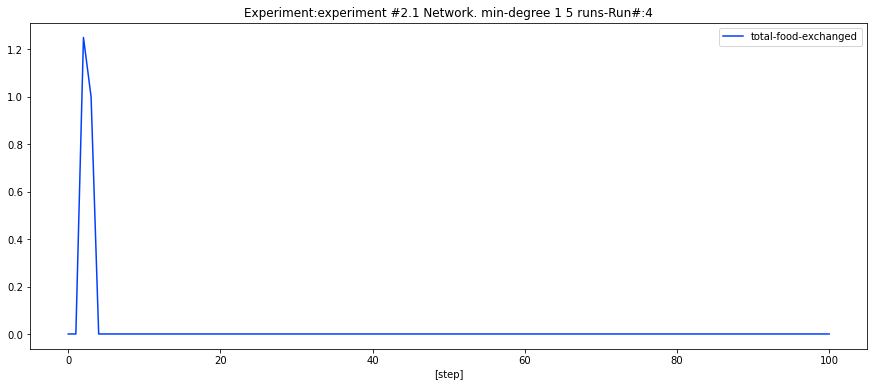

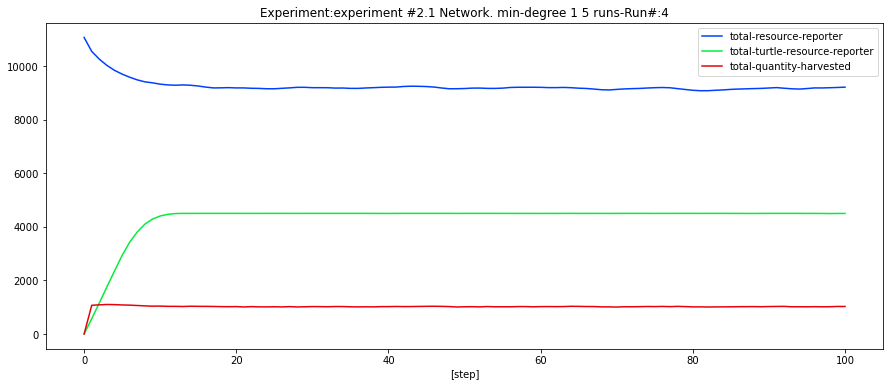

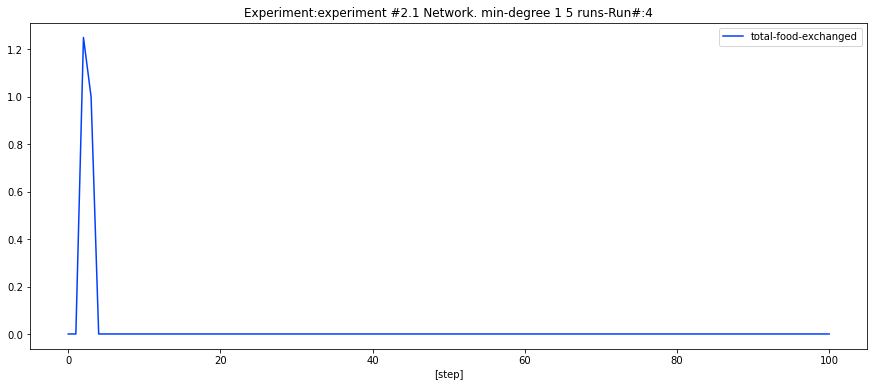

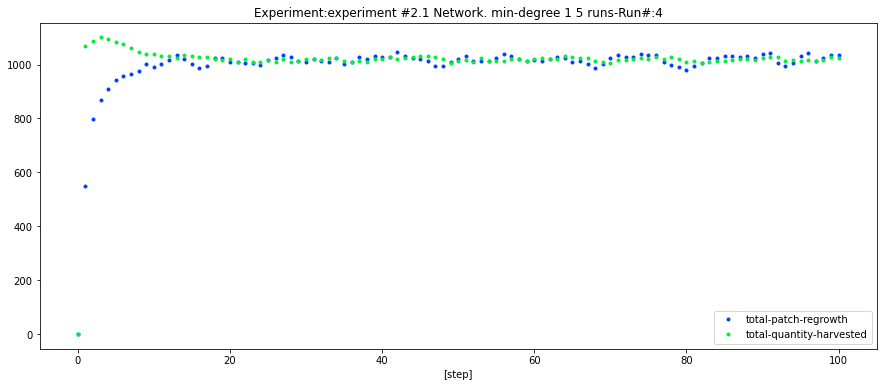

...Graph of total-resource-reporter vs ticks


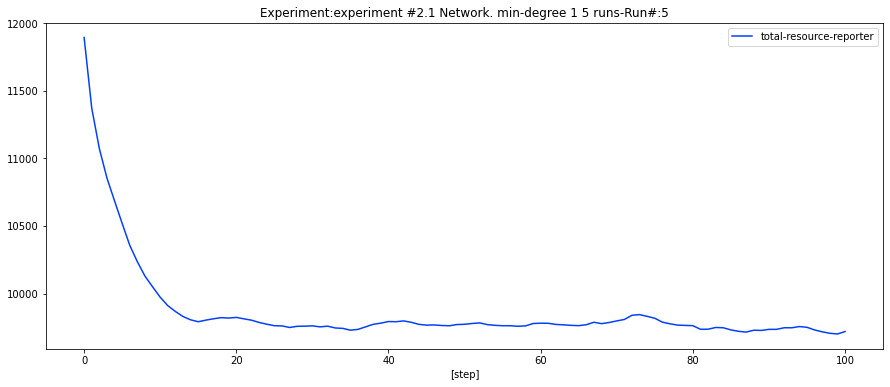

...Graph of total-patch-regrowth vs ticks


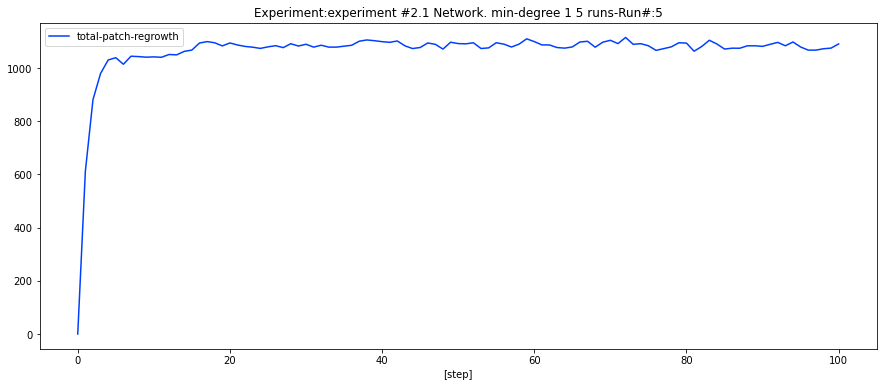

...Graph of total-turtle-resource-reporter vs ticks


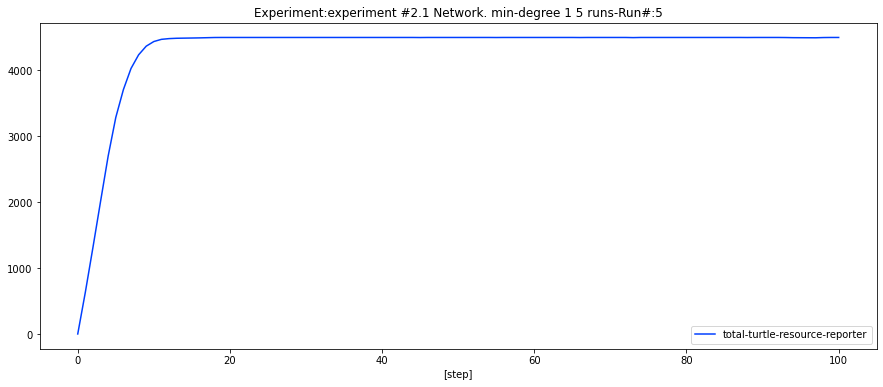

...Graph of total-quantity-harvested vs ticks


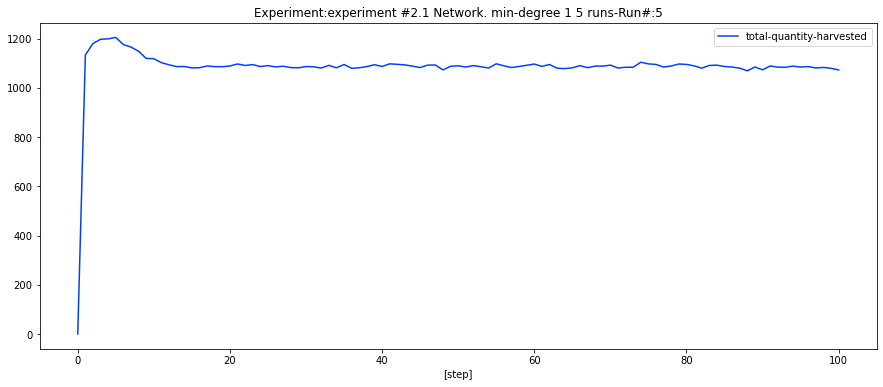

...Graph of number-of-hungry-turtles vs ticks


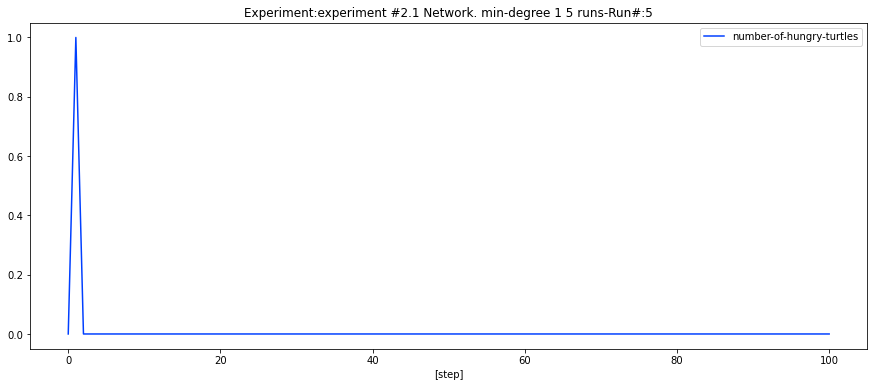

...Graph of total-wealth vs ticks


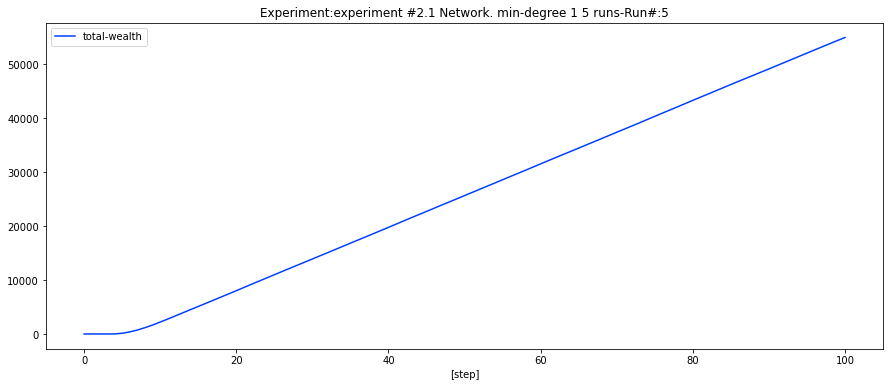

...Graph of total-food-exchanged vs ticks


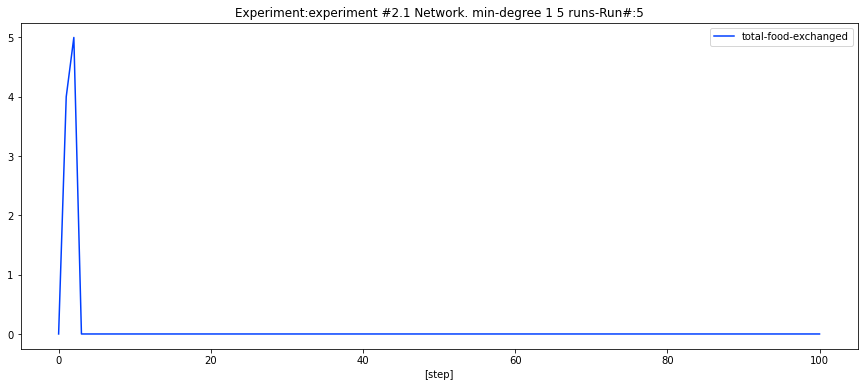

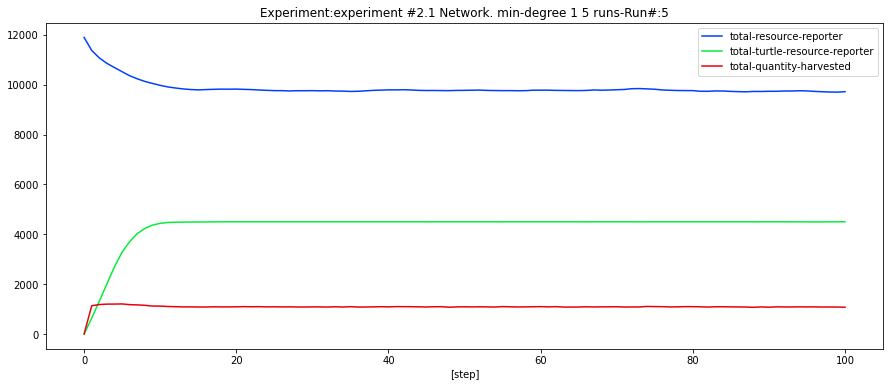

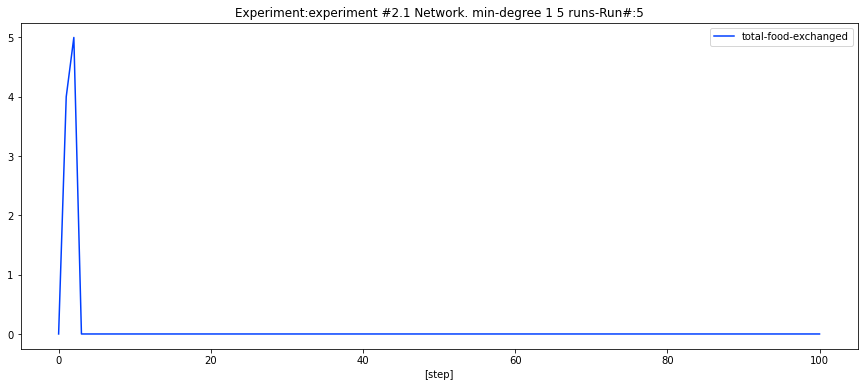

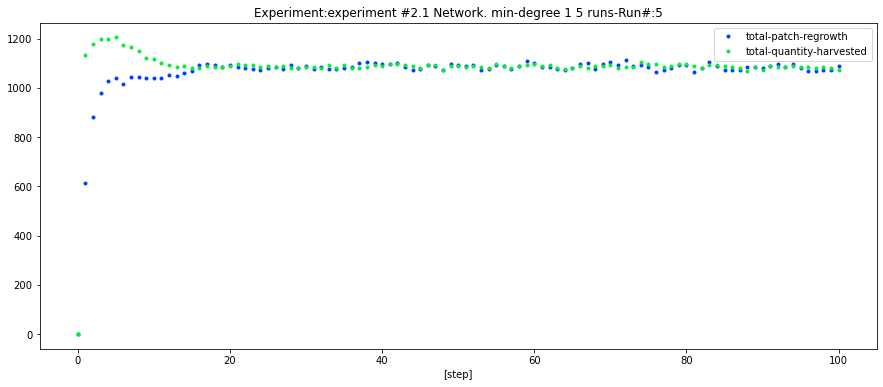

Processing experiment : experiment demo
..Processing run number : 1
...Graph of total-resource-reporter vs ticks


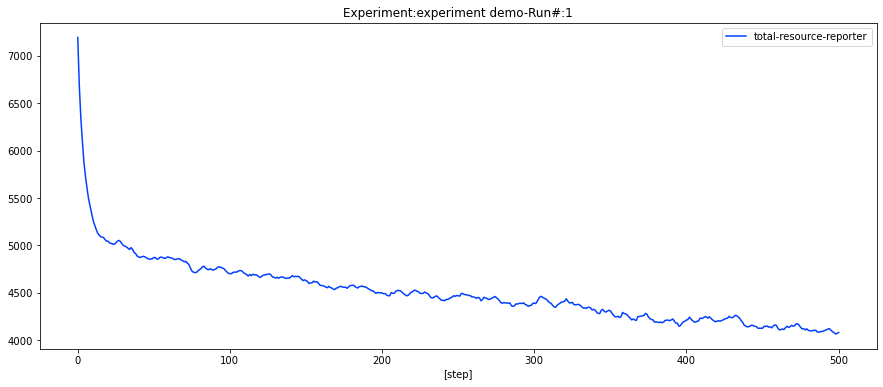

...Graph of total-patch-regrowth vs ticks


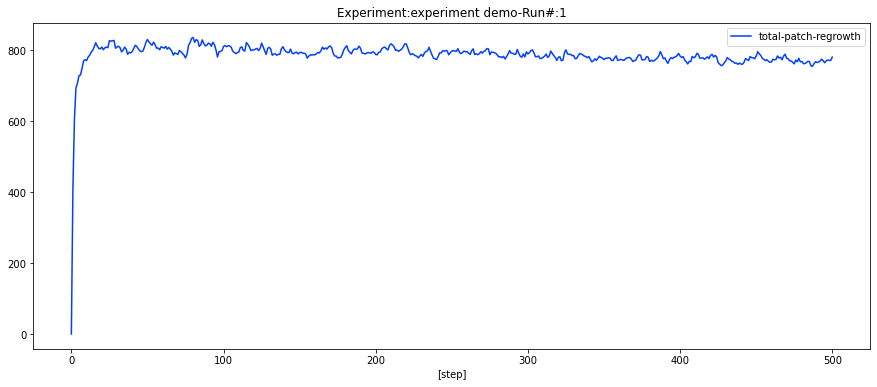

...Graph of total-turtle-resource-reporter vs ticks


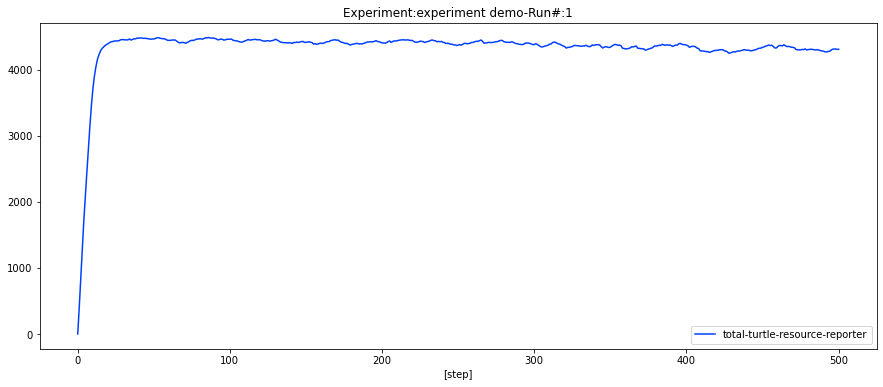

...Graph of total-quantity-harvested vs ticks


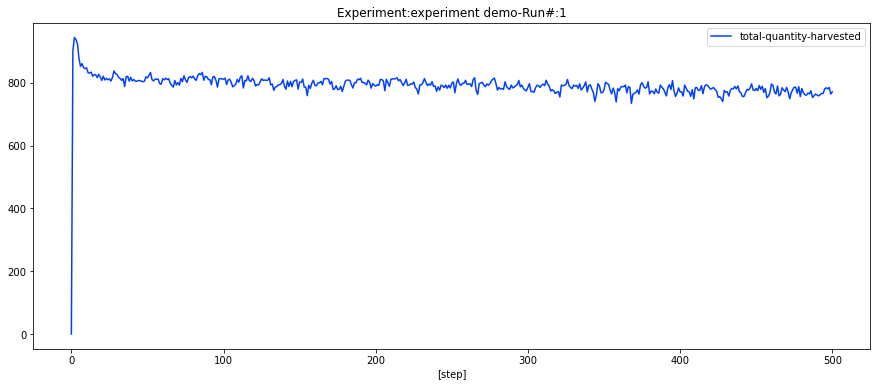

...Graph of number-of-hungry-turtles vs ticks


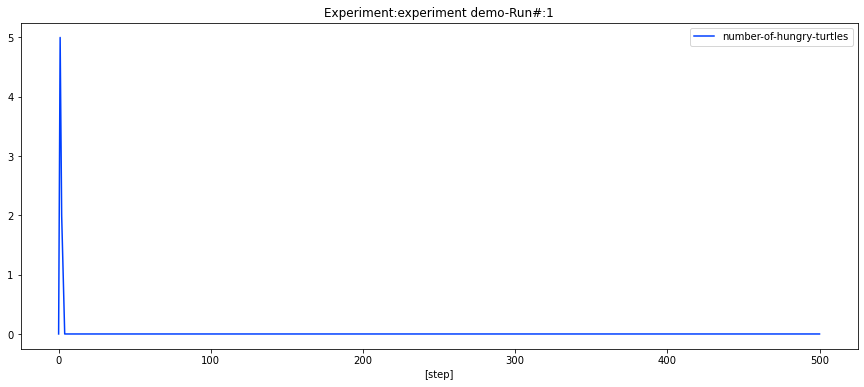

...Graph of total-wealth vs ticks


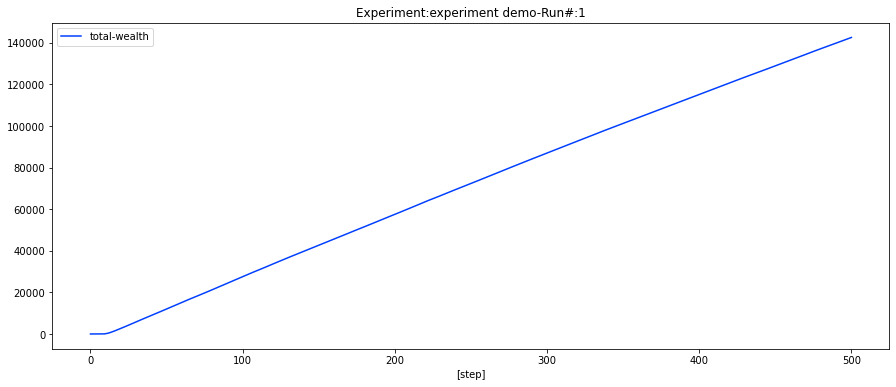

...Graph of total-food-exchanged vs ticks


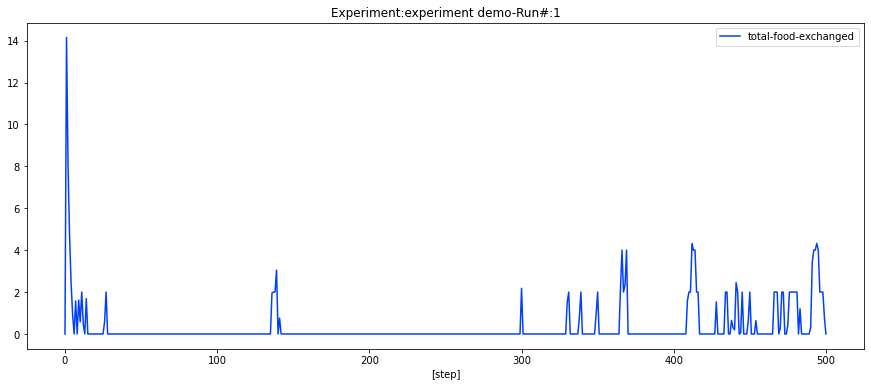

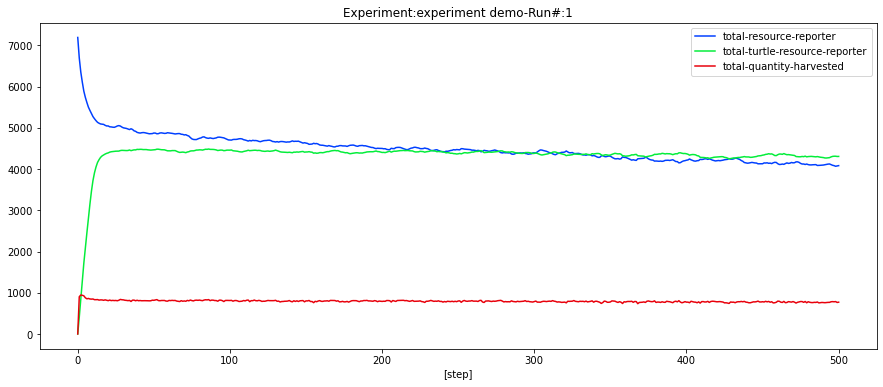

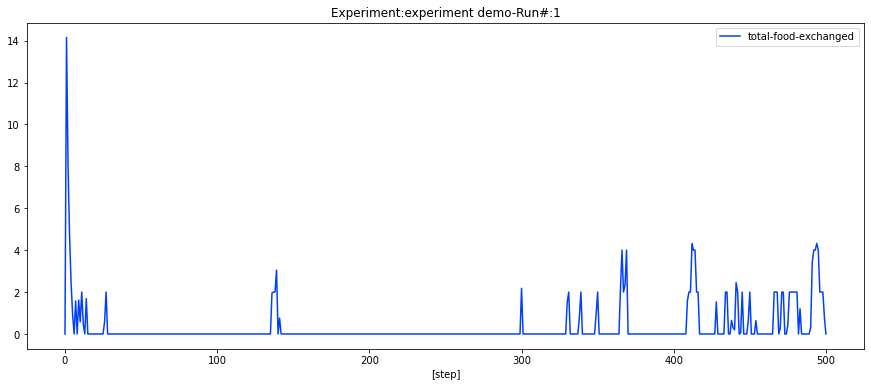

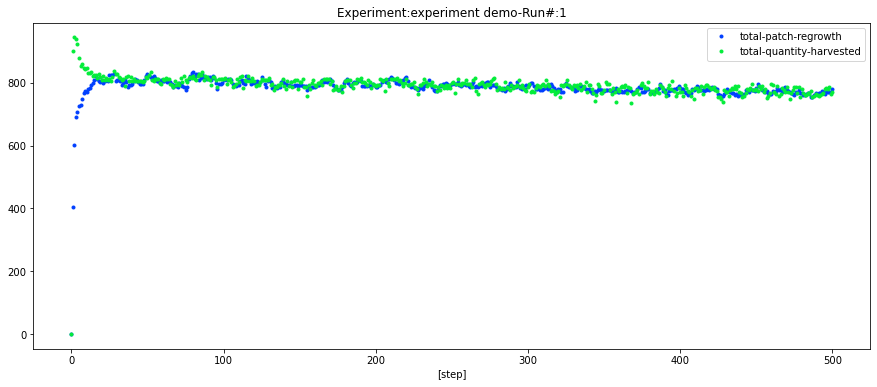

...Graph of total-resource-reporter vs ticks


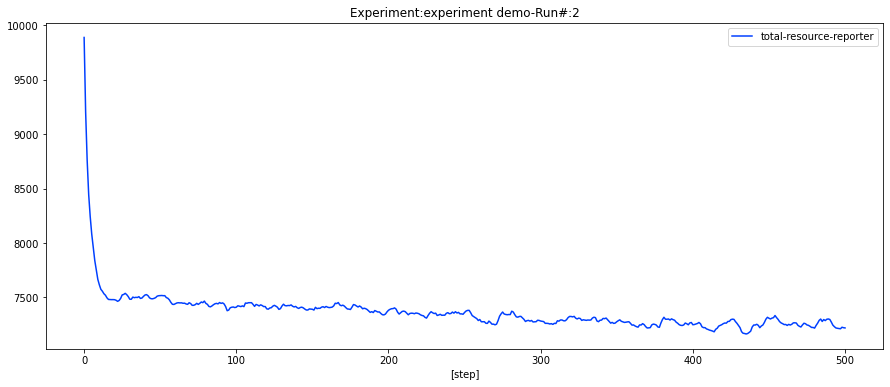

...Graph of total-patch-regrowth vs ticks


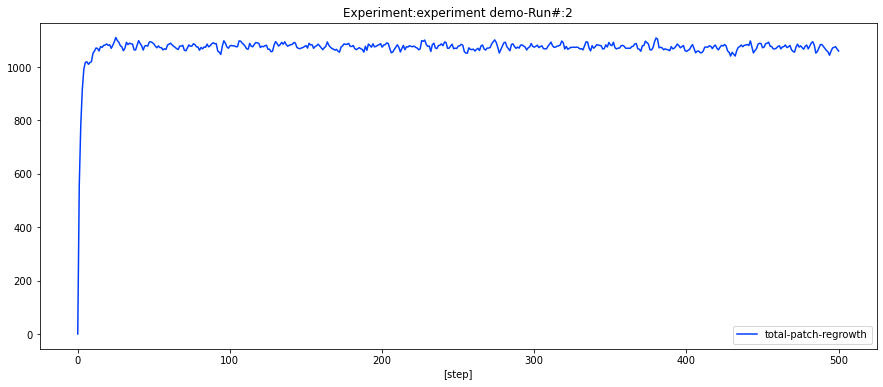

...Graph of total-turtle-resource-reporter vs ticks


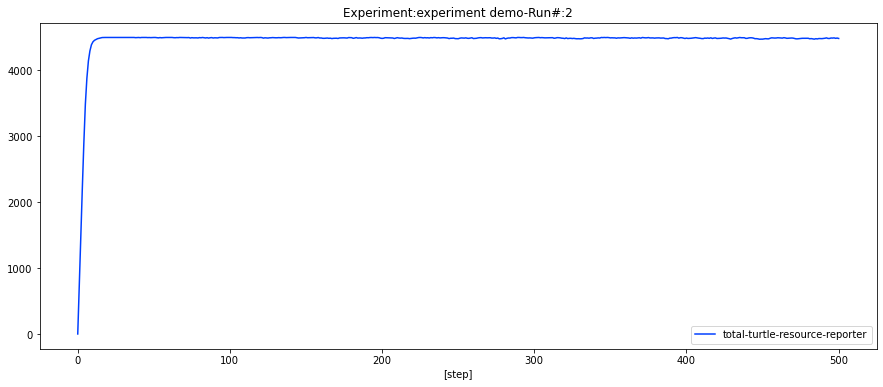

...Graph of total-quantity-harvested vs ticks


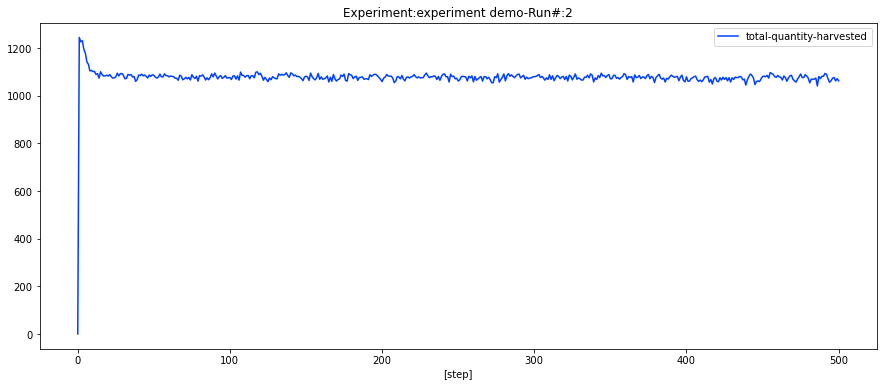

...Graph of number-of-hungry-turtles vs ticks


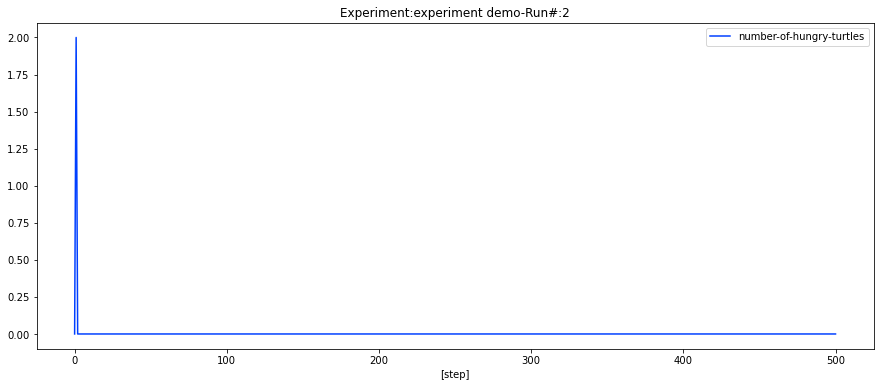

...Graph of total-wealth vs ticks


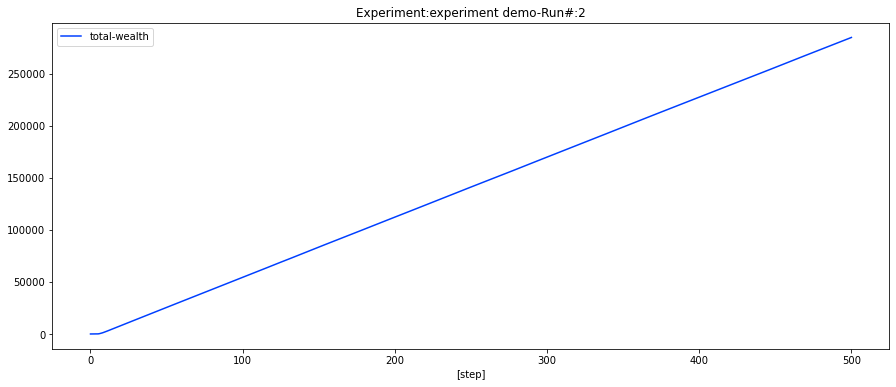

...Graph of total-food-exchanged vs ticks


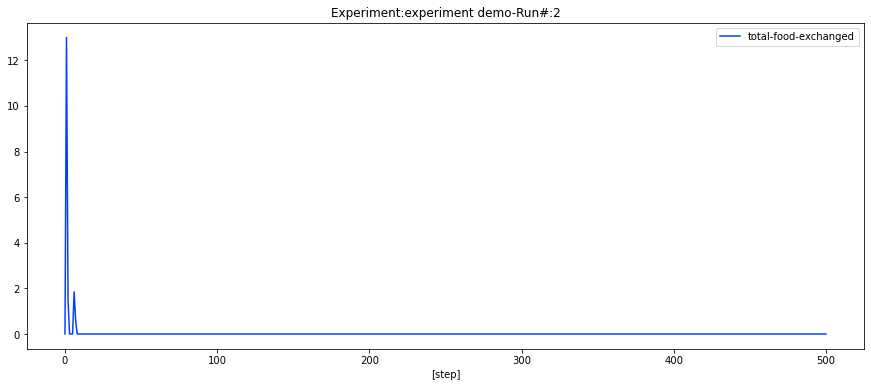

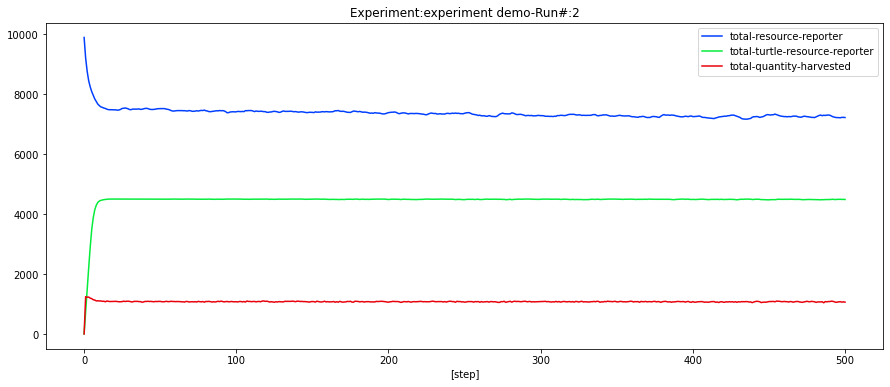

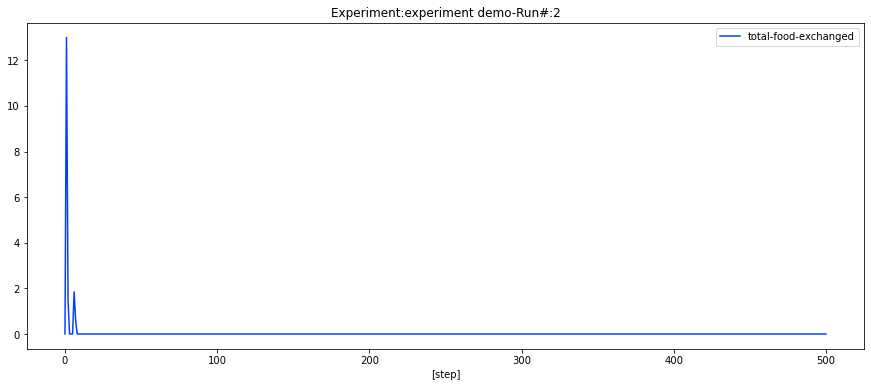

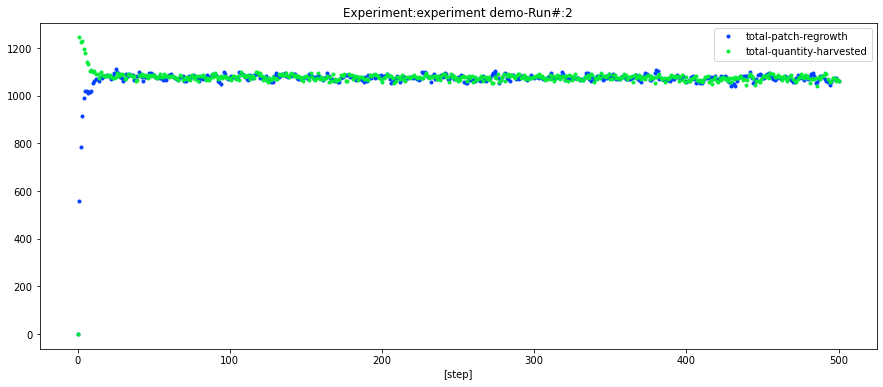

...Graph of total-resource-reporter vs ticks


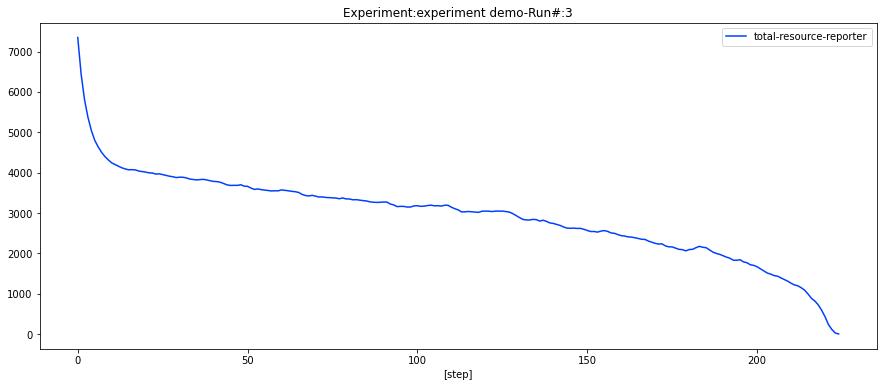

...Graph of total-patch-regrowth vs ticks


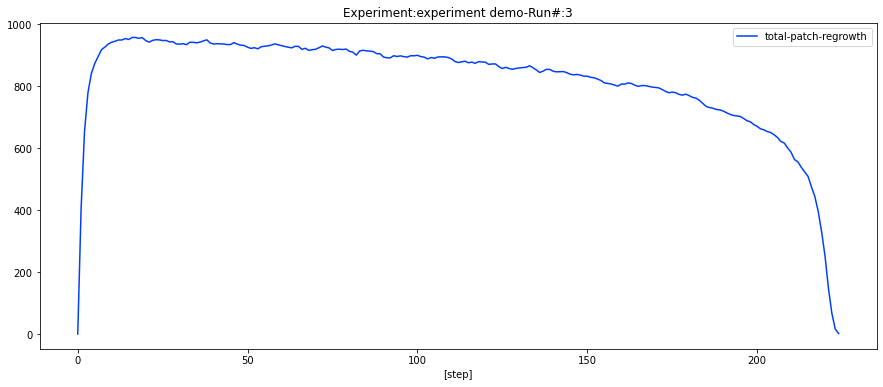

...Graph of total-turtle-resource-reporter vs ticks


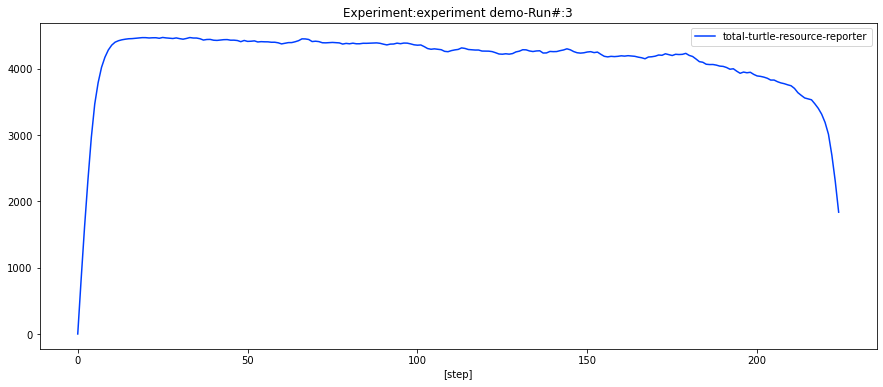

...Graph of total-quantity-harvested vs ticks


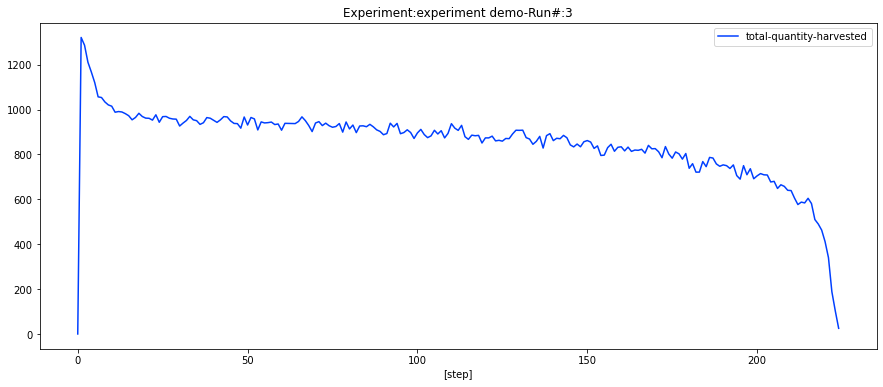

...Graph of number-of-hungry-turtles vs ticks


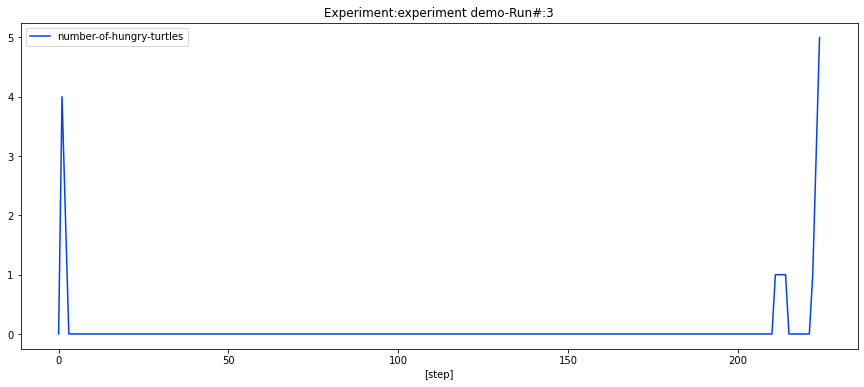

...Graph of total-wealth vs ticks


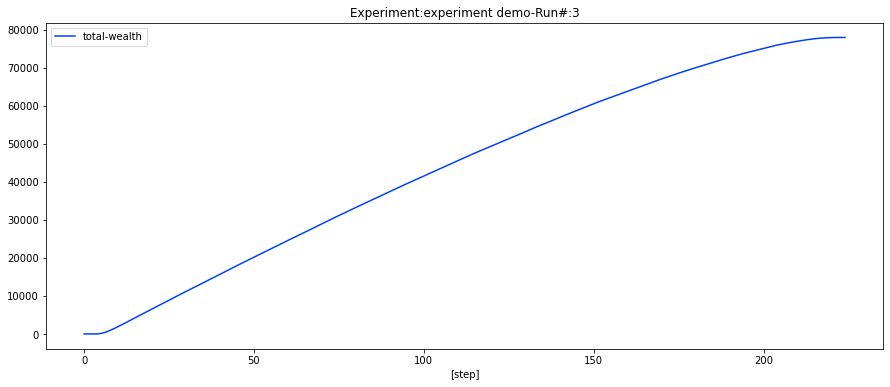

...Graph of total-food-exchanged vs ticks


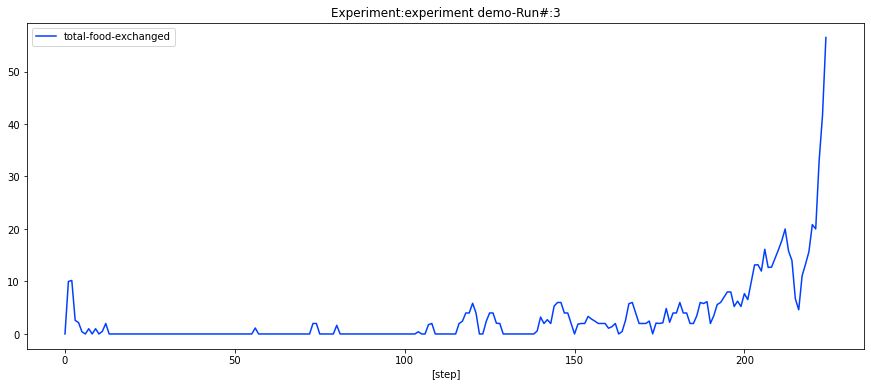

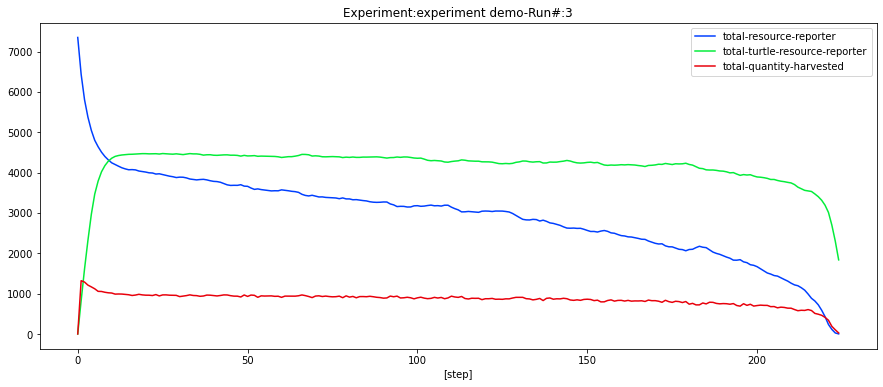

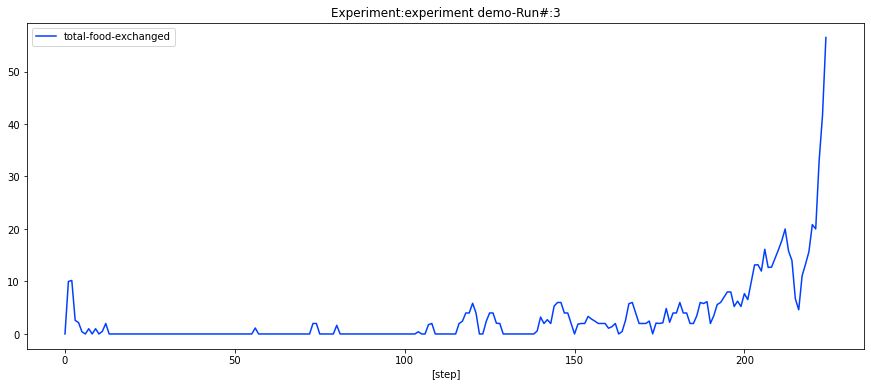

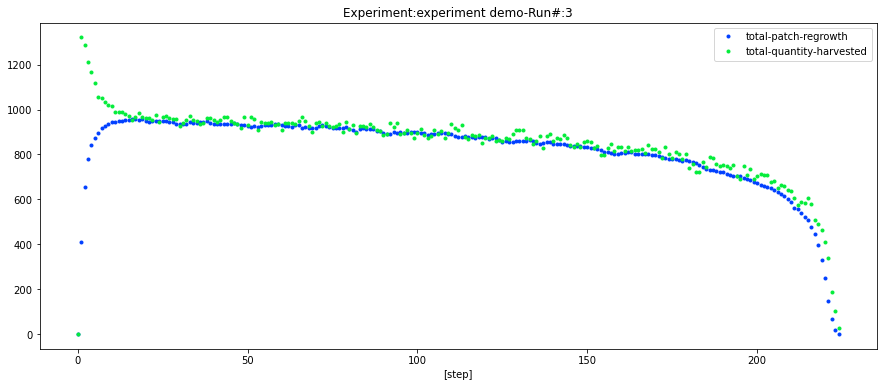

...Graph of total-resource-reporter vs ticks


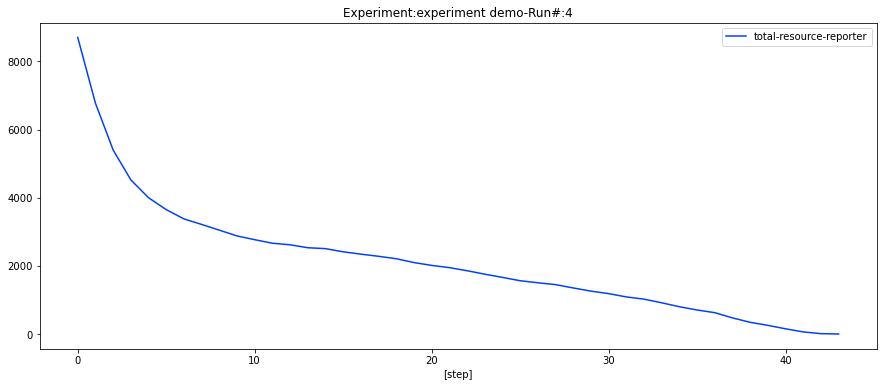

...Graph of total-patch-regrowth vs ticks


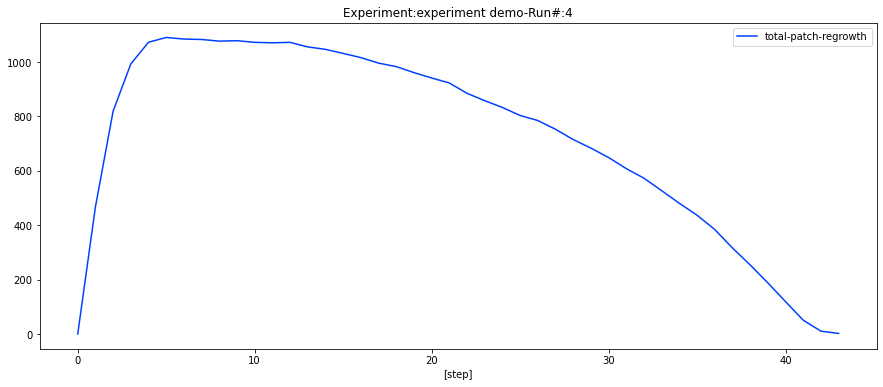

...Graph of total-turtle-resource-reporter vs ticks


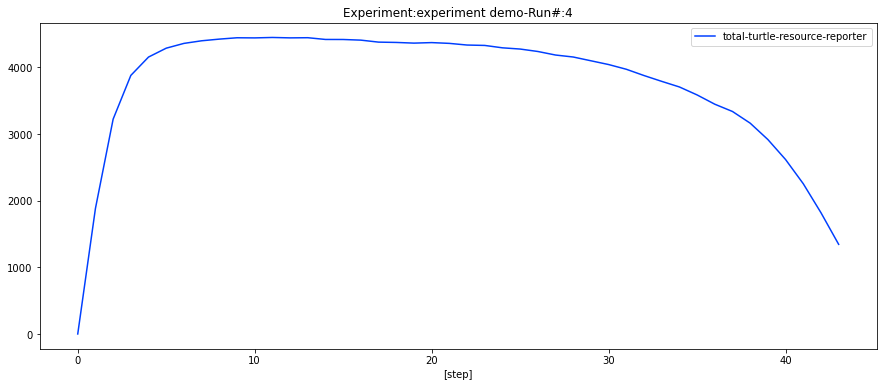

...Graph of total-quantity-harvested vs ticks


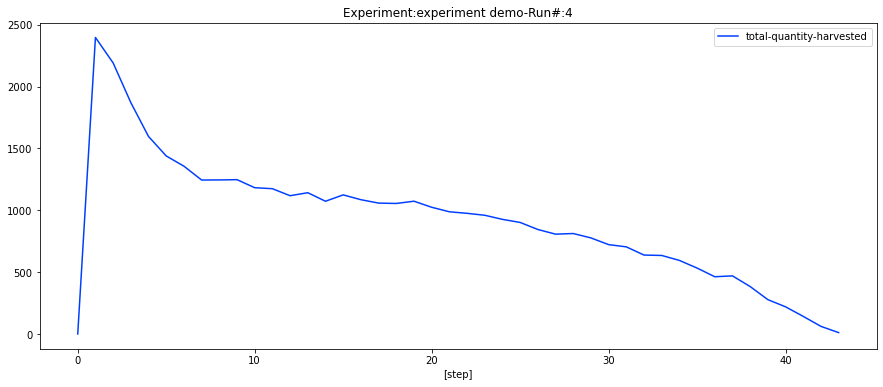

...Graph of number-of-hungry-turtles vs ticks


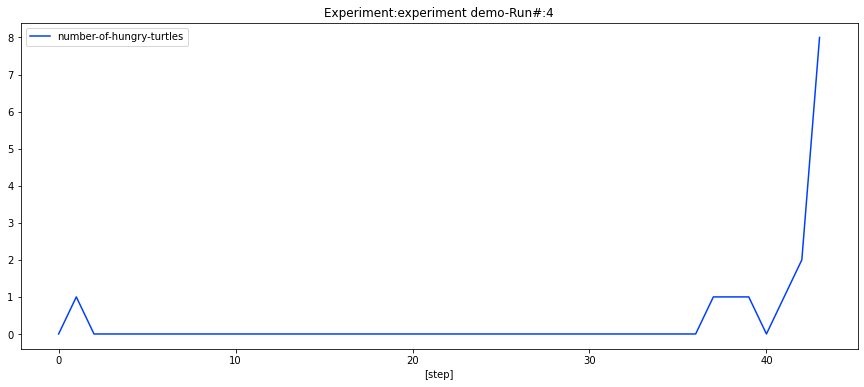

...Graph of total-wealth vs ticks


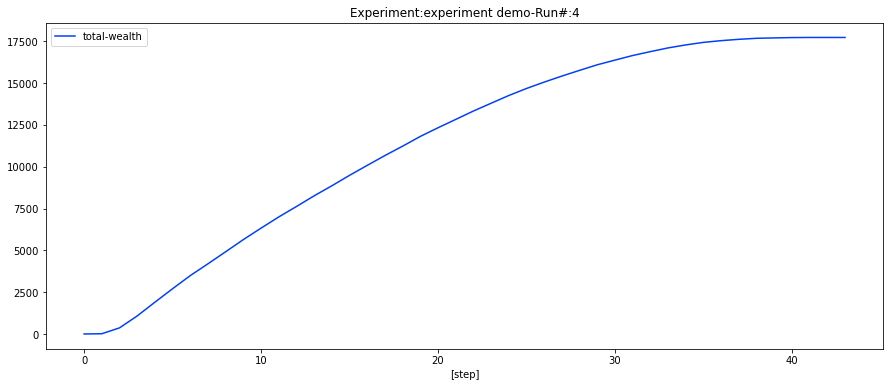

...Graph of total-food-exchanged vs ticks


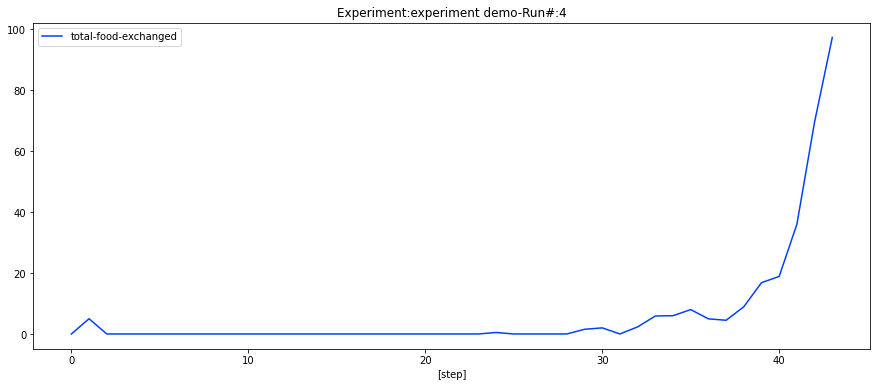

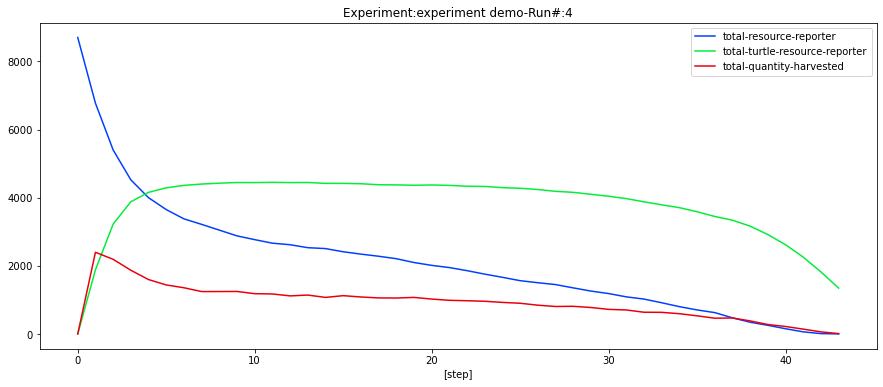

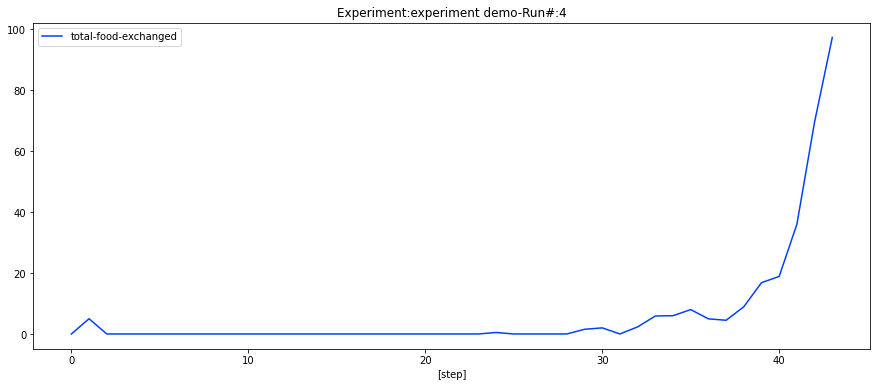

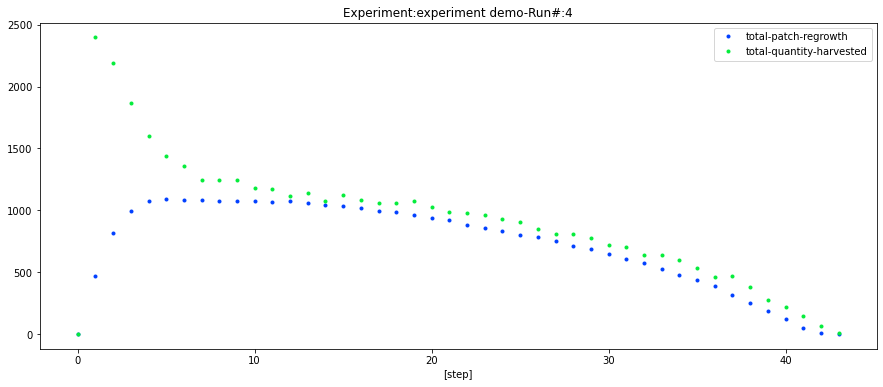

In [334]:
#############  MAIN (2) This time load all your files in one go ##################
#  
# >>>> provided path is correctly set to point to the folder containing 'data' folder where
# >>>> all the csv are stored
# >>>> e.g. path = Path('/home/isischameleon/Dropbox/Coding/gitrepos/abm_commons_tragedy') 
# >>>> this will load all csv and produce all graphs for each experiment and each run in the experiment

path = Path('/home/isischameleon/Dropbox/Coding/gitrepos/abm_commons_tragedy') 
df = load_experiments_csv_files()
df.sort_index(inplace=True)
df.to_csv(path/'data'/'debug'/'global_csv.csv', sep=',', encoding='utf-8')
process_netlogo_experiments_global(df)


Generating graph for run number :  1
Generating graph for run number :  2
Generating graph for run number :  3
Generating graph for run number :  4


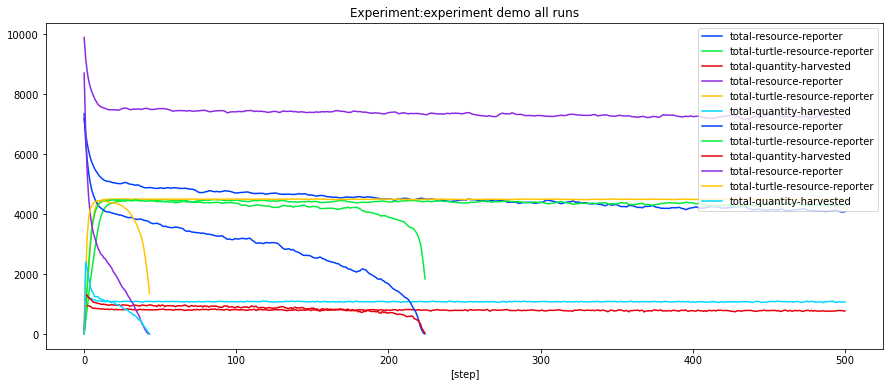

In [363]:
################  TEST MAIN ####################333

generate_all_reports_per_experiment(df, 'experiment demo')

In [280]:
global_df.head()

""
